# Overview of the BindingDB dataset

The aim of this section is to inspect and analyze the BindingDB dataset on a general level. This overview of the dataset ensures the remainder of the analyses rely on solid, foundational knowledge of the availability and distribution of the given data. In addition, this highlights biases that may arise from the data itself. Thus, we propose to inspect the data by categories that will be analyzed in depth in subsequent section. In particular, this section offers an overview of Binding Kinetics, data related to targets and ligands (IDs, names, sequences, etc.), and metadata (publications, institutions, patents, etc.)

##### Loading Data and Defining Categories

We load here the necessary data, focusing on the main dataset, and divide this data into several categories

In [1]:
# IMPORTS
# base
import pandas as pd
import numpy as np
import itertools
from itertools import combinations
import json
from bs4 import BeautifulSoup
import re

# cleaning
from src.utils.utils import group_categories
from src.utils.utils import count_classified_rows

# importing from scripts
from src.scripts import targets

# stats
import statsmodels.formula.api as smf

# plots
import seaborn as sns
from matplotlib import pyplot as plt
from src.scripts.data_description import (
    plot_availability,
    plot_distributions,
    plot_overlaps,
    categorical_countplot,
)

import warnings

warnings.filterwarnings("ignore")

In [2]:
usecols = [
    "BindingDB Reactant_set_id",
    "Ligand SMILES",
    "Ligand InChI",
    "Ligand InChI Key",
    "BindingDB MonomerID",
    "BindingDB Ligand Name",
    "Target Name",
    "Target Source Organism According to Curator or DataSource",
    "Ki (nM)",
    "IC50 (nM)",
    "Kd (nM)",
    "EC50 (nM)",
    "kon (M-1-s-1)",
    "koff (s-1)",
    "pH",
    "Temp (C)",
    "Curation/DataSource",
    "Article DOI",
    "BindingDB Entry DOI",
    "PMID",
    "PubChem AID",
    "Patent Number",
    "Authors",
    "Institution",
    "Ligand HET ID in PDB",
    "PDB ID(s) for Ligand-Target Complex",
    "PubChem CID",
    "PubChem SID",
    "ChEBI ID of Ligand",
    "ChEMBL ID of Ligand",
    "DrugBank ID of Ligand",
    "IUPHAR_GRAC ID of Ligand",
    "KEGG ID of Ligand",
    "ZINC ID of Ligand",
    "Number of Protein Chains in Target (>1 implies a multichain complex)",
    "BindingDB Target Chain Sequence",
    "PDB ID(s) of Target Chain",
    "UniProt (SwissProt) Recommended Name of Target Chain",
    "UniProt (SwissProt) Entry Name of Target Chain",
    "UniProt (SwissProt) Primary ID of Target Chain",
    "UniProt (TrEMBL) Primary ID of Target Chain",
]

In [3]:
df = pd.read_csv(
    r"data/BindingDB_All.tsv",
    sep="\t",
    usecols=usecols,
)

In [ ]:
# Defining categories
binding_kinetics = [
    "Ki (nM)",
    "IC50 (nM)",
    "Kd (nM)",
    "EC50 (nM)",
    "kon (M-1-s-1)",
    "koff (s-1)",
    "pH",
    "Temp (C)",
]

target_related = [x for x in usecols if "Target" in x]
ligand_related = [x for x in usecols if "Ligand" in x]
id_columns = [x for x in usecols if ("ID" in x) or ("id" in x)]
id_columns.append("Ligand InChI Key")
names = [x for x in usecols if "Name" in x]
metadata = [
    x
    for x in usecols
    if (x not in target_related)
    and (x not in ligand_related)
    and (x not in id_columns)
    and (x not in names)
    and (x not in binding_kinetics)
]

### Binding Kinetics Data

A key area for understanding ligands and targets is knowledge on the binding kinetics of such interactions. BindingDB offers various metrics of these kinetics, such as Ki, IC50, Kd, kon and koff, with variable availability. Below, we show this availability in the dataset per metric (left; numerically and visually). Here, we directly observe that many values are missing. Most notably, $k_{on}$ and $k_{off}$ are only measured for 0.03% of the given entries. At most, 66.8% of entries are measured, for the IC50 metric. 

Interestingly, some metrics seem to be available when others are not. To better understand this, we also show the overlap between pairs of metrics (right; maximal color scale is reached at the 75th percentile of all values for better visualisation). From this plot, we observe that overlap between metrics is relatively low, with a highest overlap at 5.76% between IC50 and pH. However, conclusions may still be made from low overlap. We take the overlap between Ki and IC50 as an example. Ki and IC50 are linked by the Cheng-Prusoff equation: $IC50 = Ki(1+[S]/Km)$ (for competitive binding). Thus, when data is entered in the present dataset, knowing Ki or IC50 is sufficient to describe the binding kinetics. We see this near exclusiveness on the left plot, as well as from the 0.11% overlap. However, even though the overlap is very small, given the size of the dataset, we are still able to link both metrics (see scatter plot below). Thus, we conclude that the low levels of overlaps within binding kinetics data is still sufficient for further statistical analyses in subsequent sections.

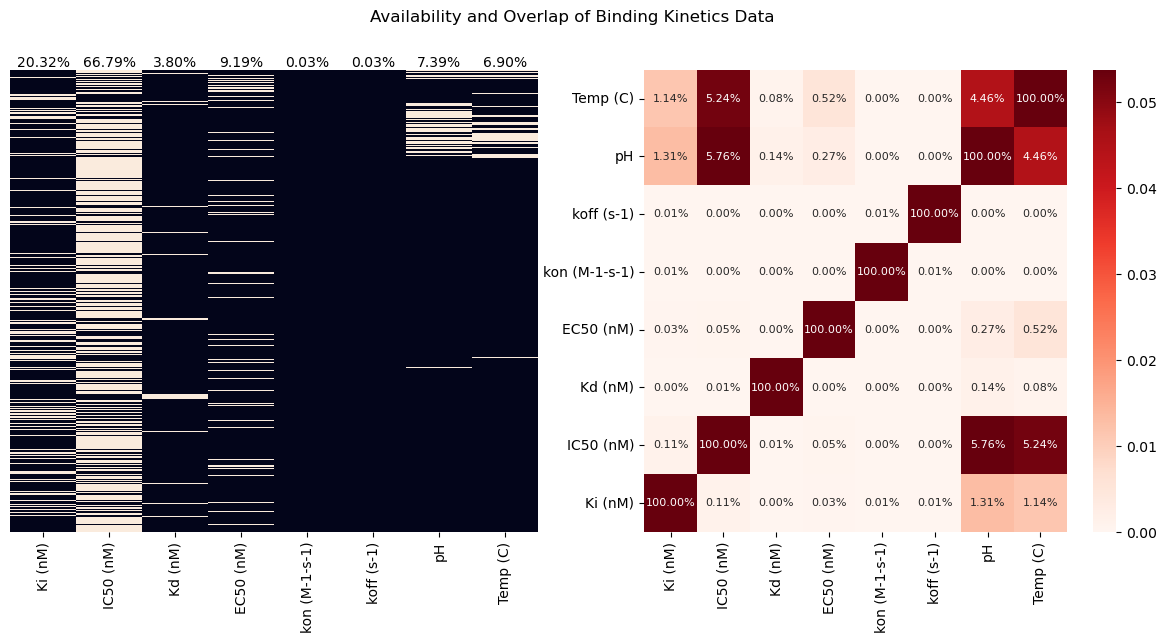

In [5]:
# availability and overlap
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
plot_availability(df=df, group=binding_kinetics, ax=axs[0])
plot_overlaps(df=df, group=binding_kinetics, ax=axs[1])
plt.suptitle("Availability and Overlap of Binding Kinetics Data")
plt.show()

In [6]:
# clean binding kinetics data
df.replace(" NV,", np.nan, inplace=True)
for col in binding_kinetics:
    df[col] = df[col].astype(str).str.replace(" C", "")
    df[col] = (
        df[col].astype(str).str.replace(">", "").str.replace("<", "").astype(float)
    )

In [7]:
# modeling example
both = df[df["IC50 (nM)"].notna() & df["Ki (nM)"].notna()][["IC50 (nM)", "Ki (nM)"]]
both_log = both.apply(np.log)
both_log = both_log.rename(columns={"Ki (nM)": "log_Ki", "IC50 (nM)": "log_IC50"})
mod = smf.ols(formula="log_Ki ~ log_IC50", data=both_log)
np.random.seed(2)
res = mod.fit()
res.summary()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 log_Ki   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.656
Method:                 Least Squares   F-statistic:                     6051.
Date:                Fri, 15 Nov 2024   Prob (F-statistic):               0.00
Time:                        17:18:50   Log-Likelihood:                -7438.3
No. Observations:                3177   AIC:                         1.488e+04
Df Residuals:                    3175   BIC:                         1.489e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.4933      0.086    -17.399      0.000      -1.662      -1.325
log_IC50       0.9294      0.012     77.790      0.000       0.906       0.953
==============================================================================
Omnibus:                      640.943   Durbin-Watson:                   0.334
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1243.980
Skew:                          -1.215   Prob(JB):                    7.47e-271
Kurtosis:                       4.868   Cond. No.                         14.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

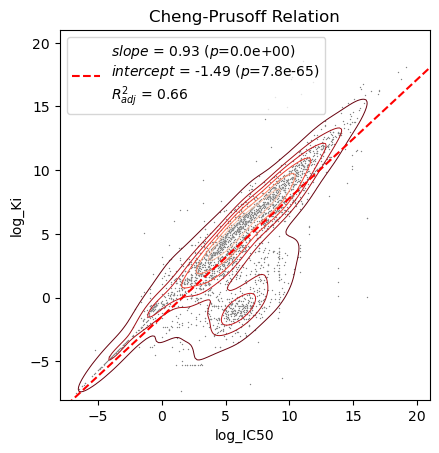

In [8]:
# plot
b, a = res.params
fig, axs = plt.subplots(1, 1)

sns.kdeplot(
    both_log[["log_Ki", "log_IC50"]].dropna(),
    y="log_Ki",
    x="log_IC50",
    levels=7,
    cmap="Reds_r",
    fill=False,
    linewidths=0.7,
    ax=axs,
)
sns.scatterplot(
    both_log[["log_Ki", "log_IC50"]].dropna(),
    y="log_Ki",
    x="log_IC50",
    s=1,
    color="grey",
    ax=axs,
)
x = np.linspace(-10, 25, num=50)
p_slope = res.pvalues["log_IC50"]
p_intercept = res.pvalues["Intercept"]
axs.plot(
    x,
    a * x + b,
    color="red",
    linestyle="--",
    label=f"$slope$ = {a:.2f} ($p$={p_slope:.1e})\n$intercept$ = {b:.2f} ($p$={p_intercept:.1e})\n$R^2_{{adj}}$ = {res.rsquared_adj:.2f}",
)
axs.set_xlim(-8, 21)
axs.set_ylim(axs.get_xlim())
axs.set_aspect("equal", adjustable="box")
axs.set_title("Cheng-Prusoff Relation")
axs.legend()
plt.show()

As discussed, the above scatter plot shows that a mere 0.11% of overlapping data is sufficient for statistical analyses. In particular, using a linear regression, we obtain the following relation: $log(Ki) = 0.93 * log(IC50) - 1.49$ ($R^2_{adj}=0.66$), or in other terms $Ki = 10^{-(-1.49)}y^{0.93}$. Thus, the slope of 0.93 (p~=0) indicates that the relation between Ki and IC50 is approximately linear, as expected from Cheng-Prusoff's relation. In addition, we observe that the $10^{-intercept}$ corresponds to $(1+[S]/Km)$. 

Interestingly, we observe two densities on the above plot, with seemingly different intercepts. This is due to different populations of ligands, with different mechanisms of action: either competitive or uncompetitive. In the uncompetitive case, the term linking Ki and IC50 is $(1+Km/[S])$, which explains the variation in intercept. Ultimately, we will use this information to cluster ligands by mechanism of action ((un)-competitive), as well as impute missing Ki and IC50 values. In future analysis, we want to reapply this linear regression, after having applied Gaussian mixture models (GMM) to separate both clusters.

On top of the availability of data presented above, we propose next show the distribution of each binding kinetics metric, overlaid with their medians, and lower and upper quartiles.

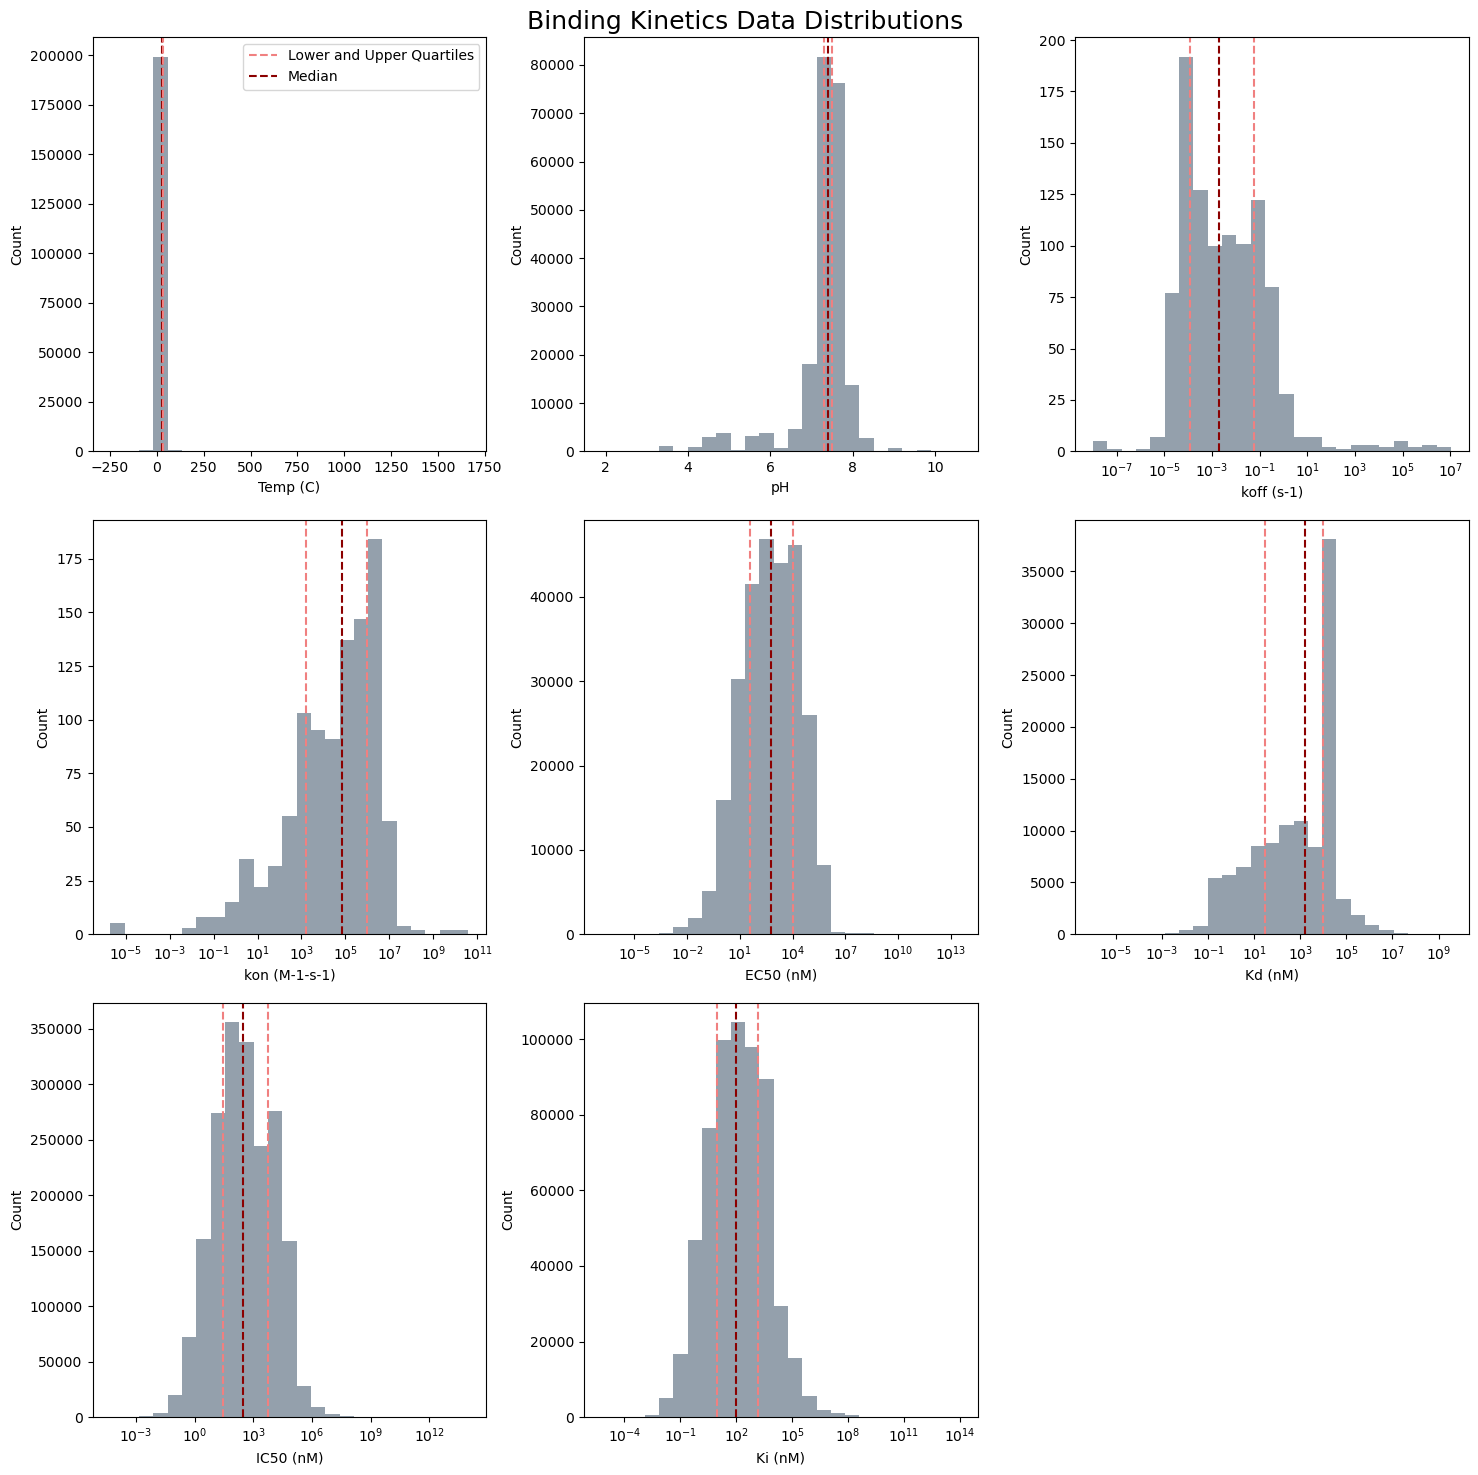

In [9]:
# data distributions
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
for idx, (col, ax) in enumerate(zip(binding_kinetics, axs.flatten())):
    if idx == 0:
        show_legend = True
    else:
        show_legend = False
    if col == "pH" or col == "Temp (C)":
        logsc = (False, False)
    else:
        logsc = (True, False)
    plot_distributions(df, col, log_scale=logsc, ax=ax, show_legend=show_legend)
plt.suptitle("Binding Kinetics Data Distributions", fontsize=18)
plt.tight_layout()
axs.flatten()[8].remove()
plt.show()

The above figure shows the distribution of each metric. In particular, we first appreciate that most measurements are made at physiological pH (around pH=7), and body temperature (around 37°C). Measures made outside these ranges are expected to be in extreme conditions or very different model organisms (see subsection on model organisms). In addition, we observe that all binding kinetics (aside pH and temperature) are "adequately" distributed on a log-scale. Importantly, on top of the numerical values found, this implies that any analyses involving binding kinetics shall preferentially be based on the logarithm of their values.

As a note, Kd sees a spike in counts between 10^4 and 10^5 nM. This is an artifact arising from the cleaning of the data, where many values are noted to pass a certain threshold (e.g. > 10^4). We note this artifact as it might introduce biases in results.

### Target and Ligand Related Data

In addition to binding kinetics, ligand and target information is crucial to this project, especially when describing molecular features that may lead to success in drug discovery. Thus, a similar data overview is proposed as above for such data (ligand structures, target sequences, IDs for external datasets, etc.). First, we show the availability of the data.

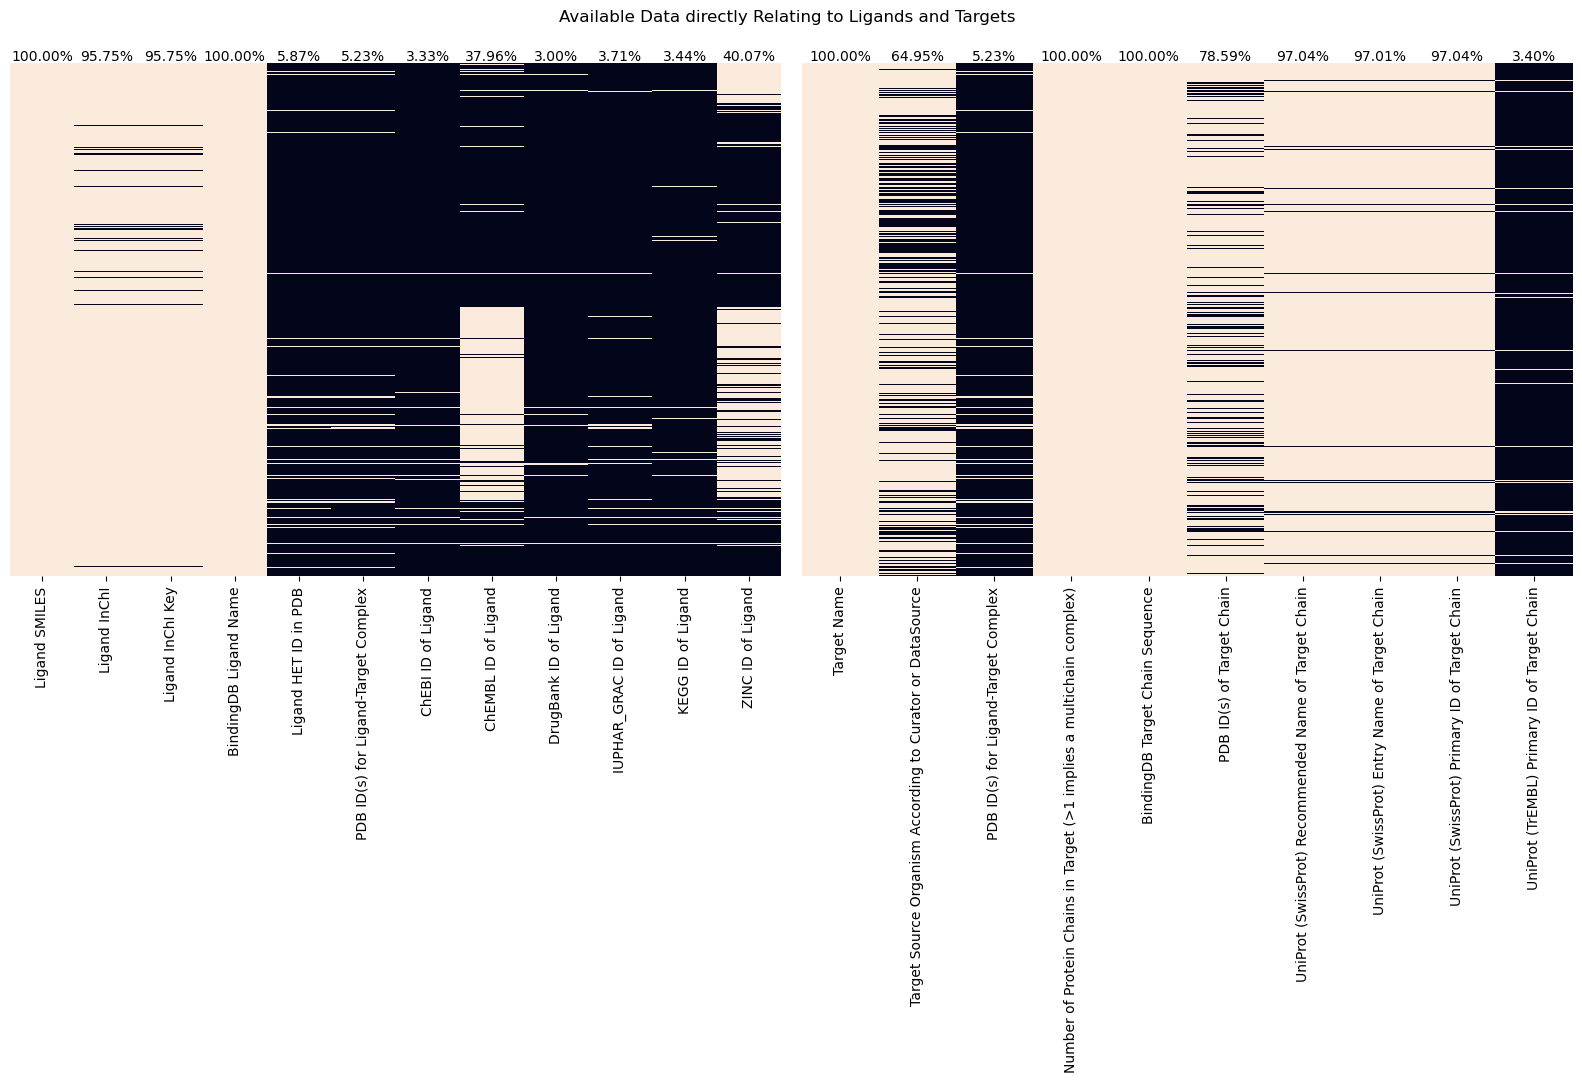

In [10]:
# availability
ligands_and_targets = list(set(ligand_related + target_related))
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 11))
plot_availability(df=df, group=ligand_related, ax=axs[0])
plot_availability(df=df, group=target_related, ax=axs[1])
plt.suptitle("Available Data directly Relating to Ligands and Targets\n")
plt.tight_layout()
plt.show()

From the above plot, we appreciate that, generally, more data is available in this category than for binding kinetics. In particular, ligand structures (SMILES) is available for 100% of entries, as is the target chain sequence. This data will be of great use in subsequent analyses, especially pertaining to molecular features. 

On the contrary, the lowest availability is observed for DrugBank IDs of ligands. Rather than a faulty database, this is actually a good primary indicator of the first steps of drug discovery. Indeed, this low attribution of DrugBank IDs may simply reflect the low success rate in the initial steps of drug discovery. In general, we are satisfied with the proportion and distribution of available data shown above, in our aim of characterizing molecular features, enriched with external datasets.

For completeness, we show the overlap between data pairs below. In general, a low overlap is often simply caused by the low availability of one item of the data pair. However, as these data are mostly used to access external datasets, we give less importance to the overlap than for data relating to binding kinetics.

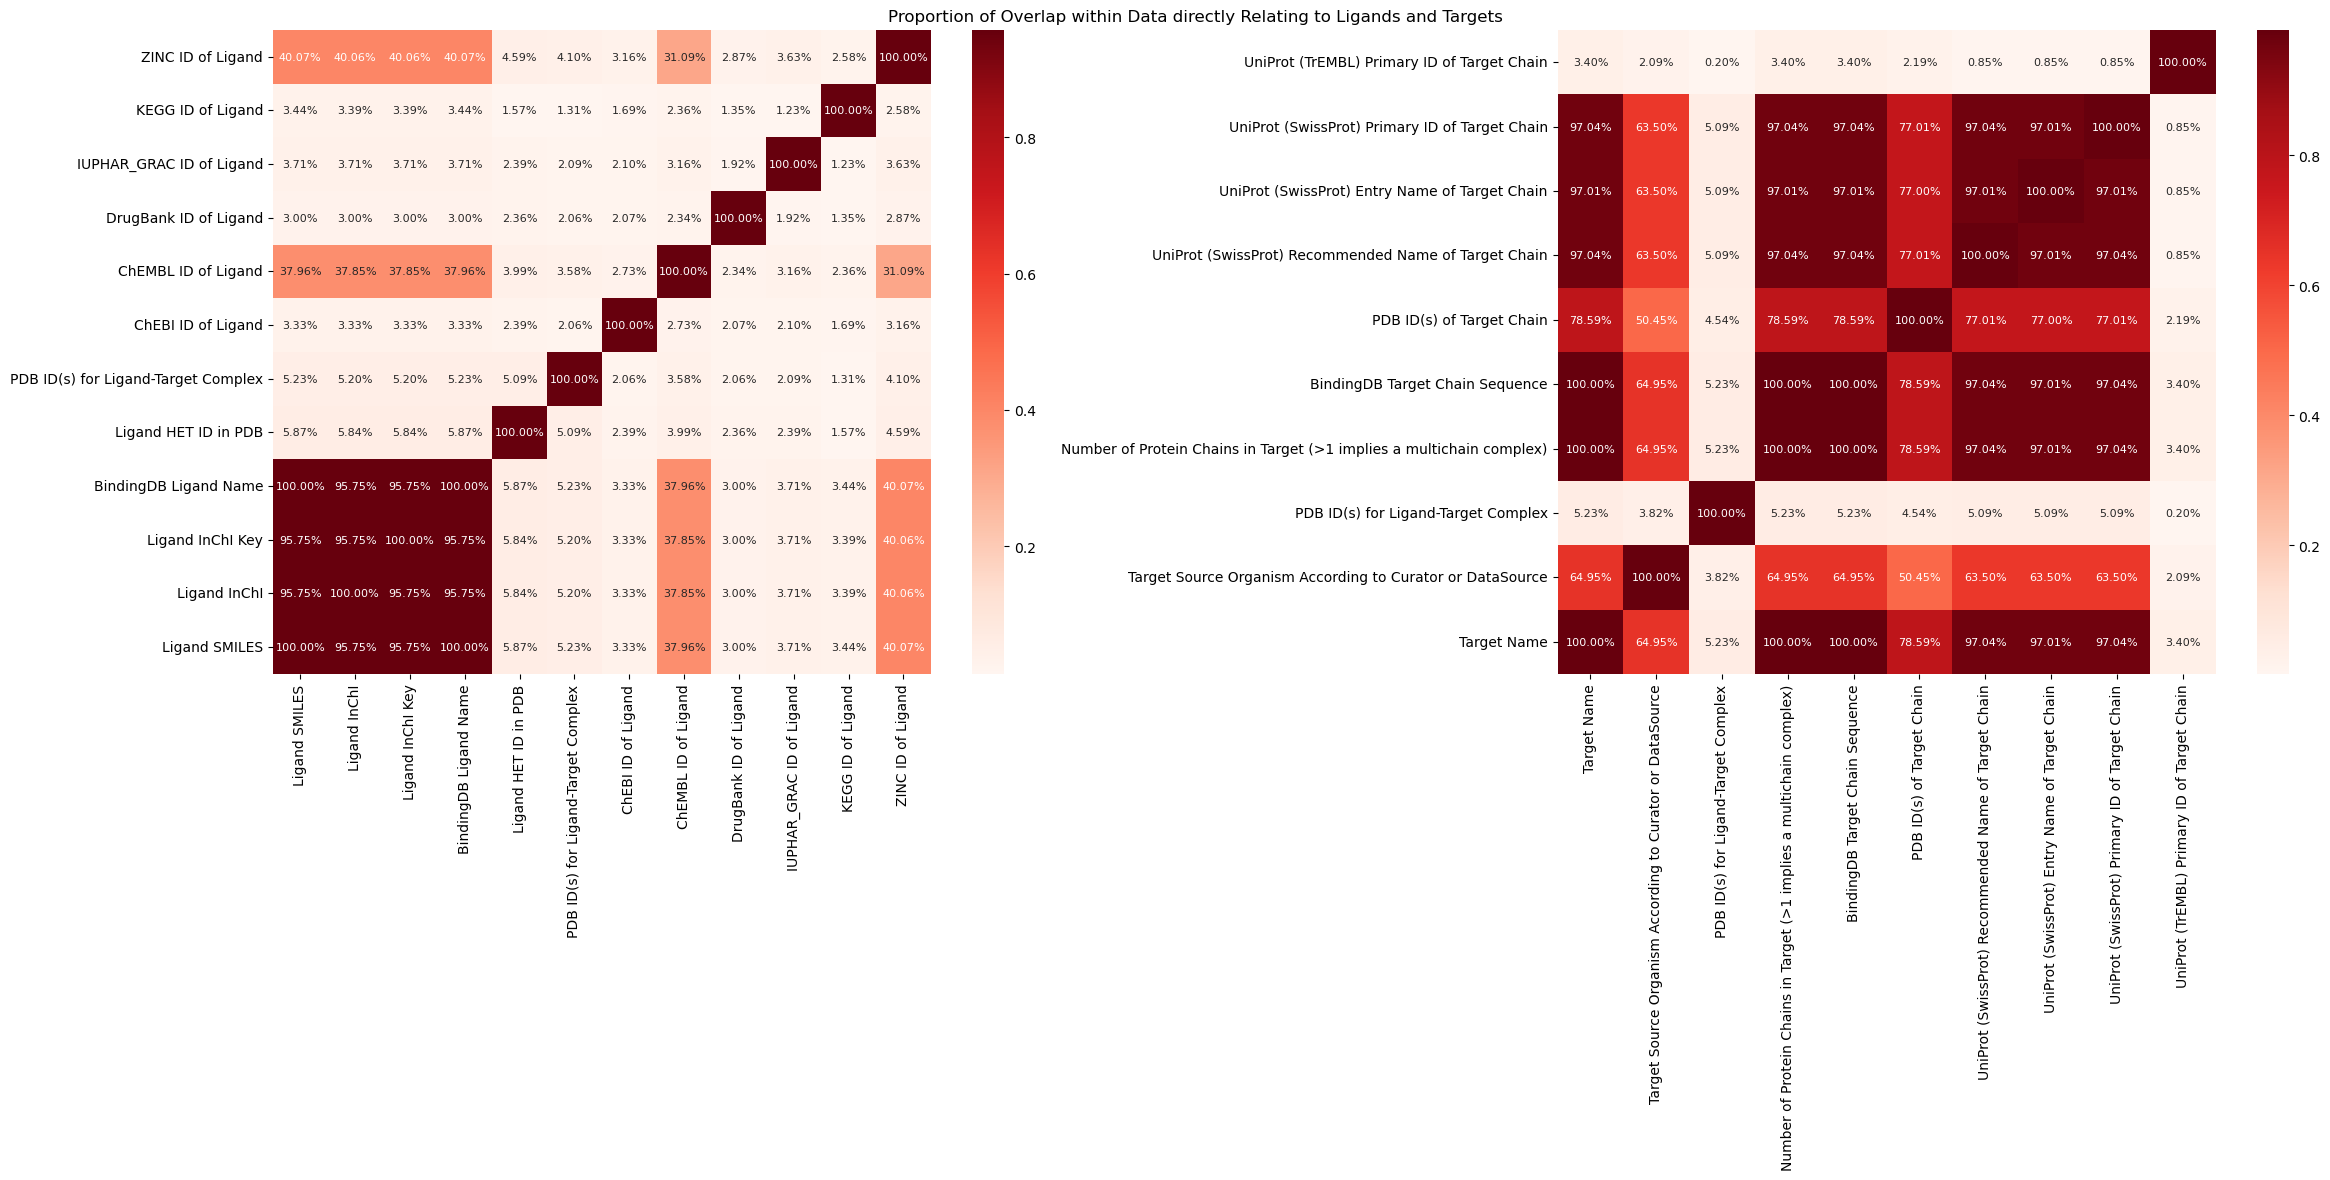

In [11]:
# overlap
fig, axs = plt.subplots(1, 2, figsize=(24, 12))
plot_overlaps(df, ligand_related, ax=axs[0])
plot_overlaps(df, target_related, ax=axs[1])
plt.suptitle(
    "Proportion of Overlap within Data directly Relating to Ligands and Targets"
)
plt.tight_layout()
plt.show()

#### Target Organisms

On top of the IDs, structures and sequences presented above, we pay particular attention to the target source organisms. Indeed, in our aim of identifying success factors in drug discovery, understanding which target organisms are used as models is a first crucial step. It is also worthy to note that many diseases in humans are actually treated by targeting other organisms' proteins, most notably in viral or bacterial infections. Thus, we show below the distribution of target organisms.

In [12]:
# cleaning target organism data
in_mapping = {
    "Human immunodeficiency virus": ["immunodeficiency virus", "hiv"],
    "Sars coronavirus": ["severe acute respiratory", "sars"],
    "Human herpes virus": ["herpes"],
    "Homo sapiens": ["h. sapiens"],
    "Mus musculus": ["mouse", "m. musculus"],
    "Rattus norvegicus": ["rattus", "r. norvegicus"],
    "Cavia porcellus": ["cavia"],
    "Hepatitis C": [],
    "Escherichia coli": ["coli"],
    "Caenorhabditis elegans": ["elegans"],
    "Influenza virus": ["influenza"],
    "Oryctolagus cuniculus": ["cuniculus"],
    "Streptococcus pyogenes": ["pyogenes"],
    "Plasmodium falciparum": [],
    "Saccharomyces cerevisiae": ["cervisiae"],
    "Streptococcus pneumoniae": [],
    "Mycobacterium tuberculosis": [],
}

f = lambda x: group_categories(
    str(x),
    in_mapping=in_mapping,
    check_key_for_in_mapping=True,
)

df["Target Source Organism According to Curator or DataSource"] = (
    df["Target Source Organism According to Curator or DataSource"]
    .apply(f)
    .apply(str.capitalize)
    .replace("Nan", np.nan)
)

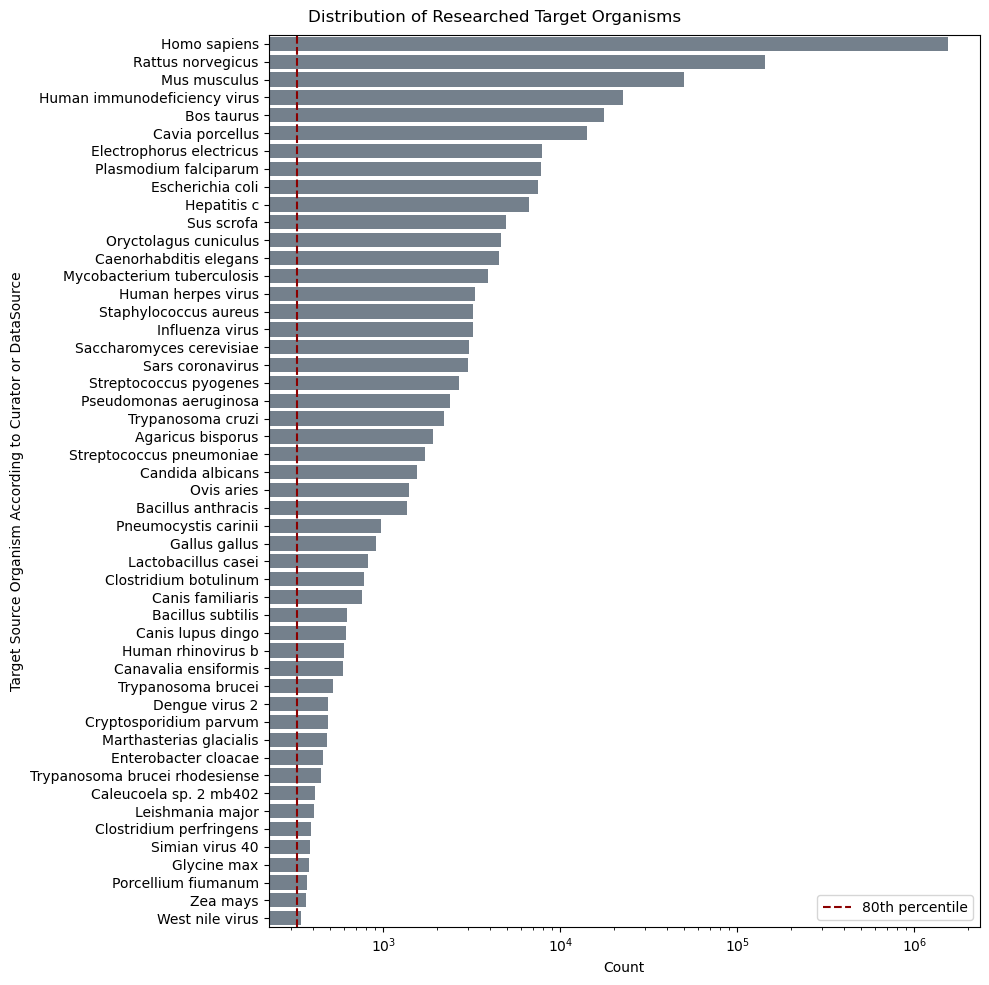

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
categorical_countplot(
    df,
    "Target Source Organism According to Curator or DataSource",
    ax=ax,
    percentile=0.8,
)
plt.suptitle("Distribution of Researched Target Organisms")
plt.tight_layout()
plt.show()

Without surprise, the above plot shows that H. sapiens is the most frequently targeted organism in research. Thereafter, are the common mice and rat models. Interestingly, these three models are used to target a large array of disease classes, as will be shown in a subsequent analysis. The fourth targeted organism however, relates to a single disease: HIV/AIDS. This highlights the importance of this disease class, for which research interest was immense, following the 1980s pandemic. This is shown below in a time series analysis. 

As mentioned above we see many examples of such viral or bacterial infections being in the top 20% studied organisms (dashed red line represents the 80th percentile of counts in the BindingDB dataset). For example, SARS coronavirus, E.coli, Herpes virus, Hepatitis C and Influenza virus are all highly studied organisms.

As an intermediate conclusion, we therefore acknowledge that targeted organisms are either models for human diseases (such as M. musculus, R. norvegicus or C. elegans) or disease causing themselves (such as the bacteria and viruses mentioned above). For our subsequent analyses, we will therefore discriminate between these classes to avoid bias, or simply focus on particular categories.

### Metadata

A final category of data of interest is metadata. Indeed, information such as article DOIs, patent numbers and institutions allows for a more complete overview of drug discovery. Indeed, key metrics of success are taken from the number of citations of a paper or patent. In addition, to understand the dynamics of drug discovery, the years of publications are highly useful for mapping drug discovery in time, while knowledge on institutions allows mapping drug discovery in space. 

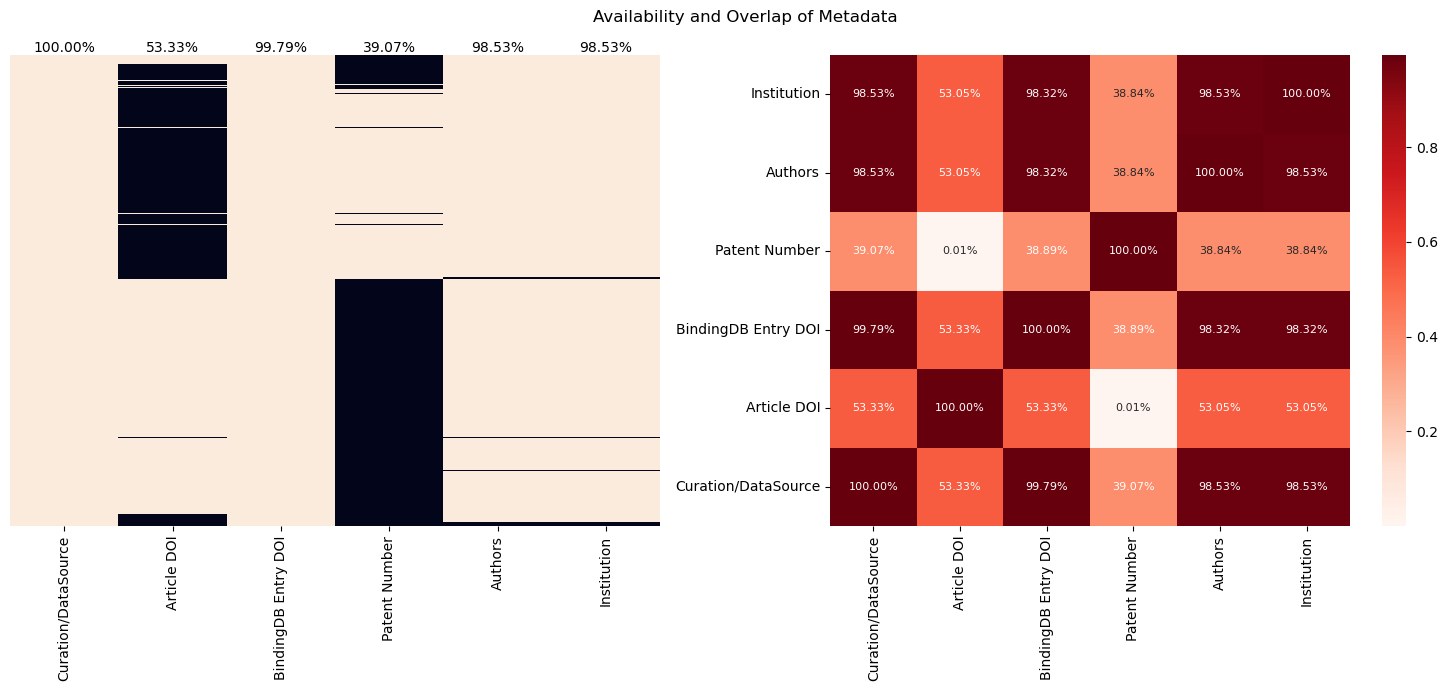

In [14]:
# availability and overlap
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
plot_availability(df=df, group=metadata, ax=axs[0])
plot_overlaps(df, metadata, ax=axs[1])
plt.suptitle("Availability and Overlap of Metadata")
plt.tight_layout()
plt.show()

The above figure shows that roughly half the entries in bindingDB are linked to a publication. Also, around 40% of entries are under a patent. Interestingly, as seen on the right plot, the overlap between Article DOIs and Patent Numbers is only 0.01%. Thus, the two categories are nearly exclusive, showing that knowledge on citations of publications and patents are complementary success indicators. Secondly, as for the low amount of DrugBank IDs, the low overlap of Article DOIs and Patent Numbers show that only very few researched compounds lead to commercial benefit, demonstrating yet another hurdle in drug discovery.

To counter this very low turnover, researchers often initially resort to high-throughput screening, with the largest of the dataset covering around 12'000 compounds. This is taken into account when using number of citations as a success metric. More particularly, citations are only one of many indicators of success. The distributions of compounds studied per article and covered per patent are shown below.

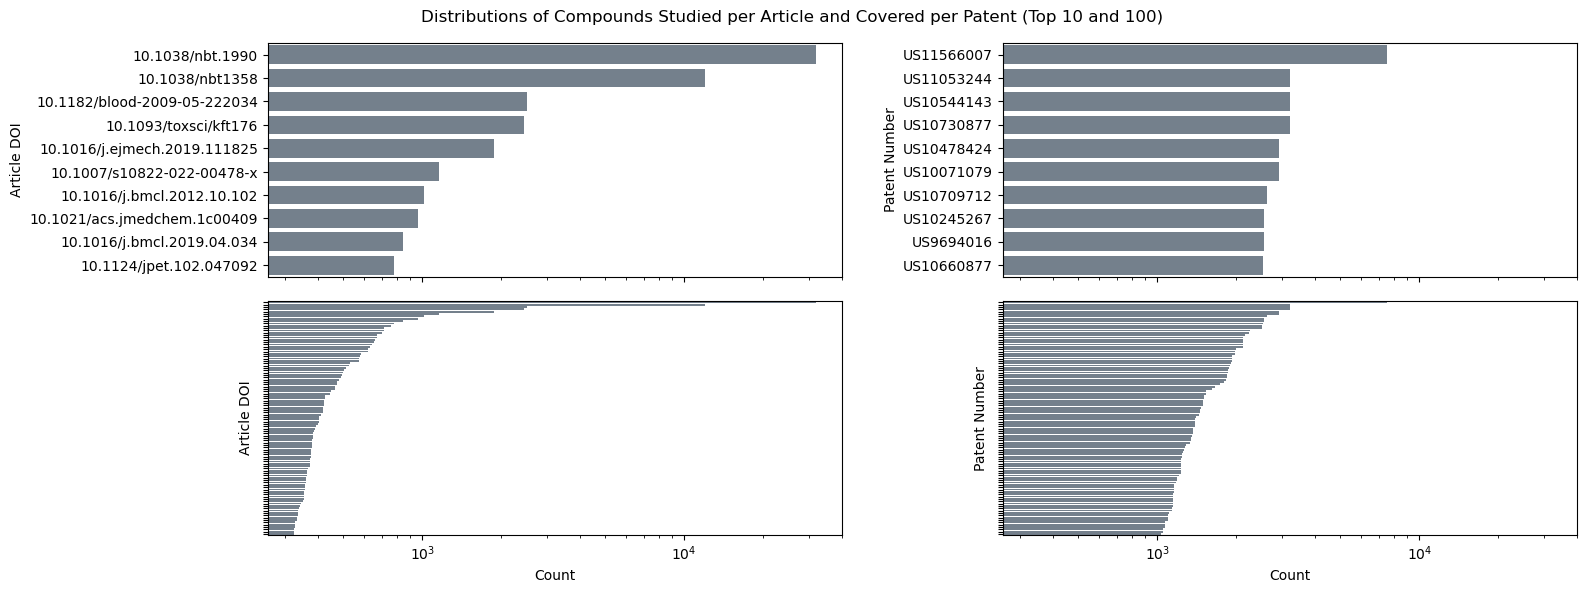

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(16, 6), sharex=True)
N1 = 100
N2 = 10
categorical_countplot(df, "Article DOI", ax=axs[1, 0], N=N1)
categorical_countplot(df, "Article DOI", ax=axs[0, 0], N=N2)
categorical_countplot(df, "Patent Number", ax=axs[1, 1], N=N1)
categorical_countplot(df, "Patent Number", ax=axs[0, 1], N=N2)
plt.suptitle(
    f"Distributions of Compounds Studied per Article and Covered per Patent (Top {N2} and {N1})"
)
plt.tight_layout()
axs[1, 0].set_yticklabels("")
axs[1, 1].set_yticklabels("")
plt.show()

As mentioned above, future analysis might rely on mapping drug discovery in space. We show here that such data is obtainable.

In [16]:
in_mapping = {
    "Pfizer": [],
    "MSD": ["Dohme"],
    "Bristol-Myers Squibb": [],
    "Amgen": [],
    "Novartis": [],
    "Janssen": [],
    "Eli Lilly": ["lilly"],
    "Roche": [],
    "Incyte": [],
    "Gilead": [],
    "Bayer": [],
    "Abbott": [],
    "Scripps Research Institute": ["scripps"],
    "The Burnham Institute": ["burnham"],
    "Genentech": [],
    "GlaxoSmithKline": ["gsk"],
    "Astrazeneca": [],
    "Abbvie": [],
    "Merck": [],
    "Boehring": [],
}

f = lambda x: group_categories(
    str(x),
    in_mapping=in_mapping,
    check_key_for_in_mapping=True,
)

df["Institution"] = (
    df["Institution"].apply(f).replace("TBA", np.nan).replace("nan", np.nan)
)  # tba = to be attributed

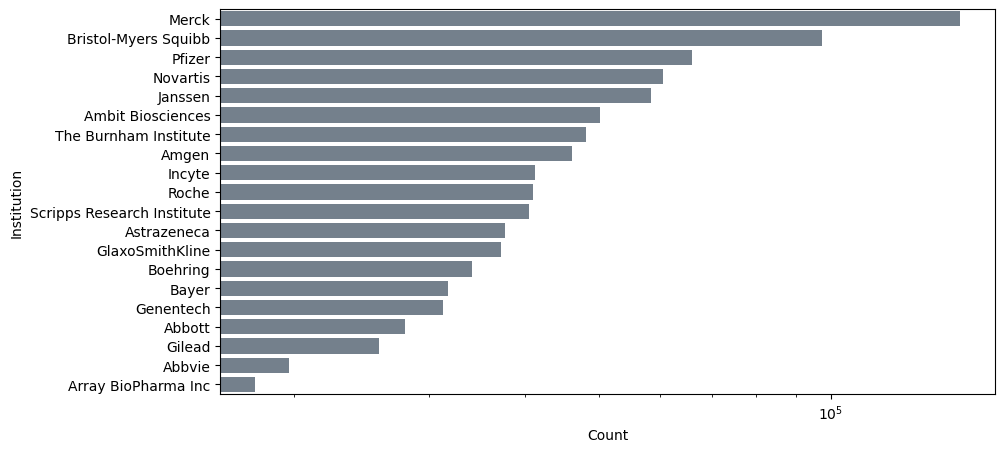

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
categorical_countplot(df, "Institution", N=20, ax=ax)
plt.show()

The figure above shows the distribution of the top 20 institution in the BindingDB dataset.

---

# Disease Classification

In [18]:
from src.scripts.disease_plotting import (
    load_uniprotid_diseases,
    quantify_missing_diseases,
    add_keywords_when_comments_missing,
    sort_diseases,
)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import plotly.express as px

import warnings

warnings.filterwarnings("ignore")

In [19]:
bindingdb_df = pd.read_csv(
    r"./data/BindingDB_All.tsv",
    sep="\t",
    usecols=["UniProt (SwissProt) Primary ID of Target Chain", "Article DOI"],
)

We now load the `src/data/UniprotID_disases.json` file which was generated using the following script in roughly 30 mins:

```py
from src.scripts.uniprot import get_uniprot_diseases
import os

get_uniprot_diseases(
    bindingdb_df["UniProt (SwissProt) Primary ID of Target Chain"].value_counts().index,
    savename=os.path.join(
        "src",
        "data",
        "UniprotID_disases.json",
    ),
)
```

The function `get_uniprot_diseases` uses an Uniprot API call to retrieve disease information. An Uniprot ID can be linked to more than one disease.

In [20]:
diseases = load_uniprotid_diseases()
ids_missing_diseases, percentage_missing = quantify_missing_diseases(diseases)
diseases_df = add_keywords_when_comments_missing(diseases)

print(
    f"Percentage of Uniprot IDs missing a disease description : {percentage_missing:.2f}%"
)
print(
    f"One random missing ID: https://www.uniprot.org/uniprotkb/{ids_missing_diseases[42]}"
)

Percentage of Uniprot IDs missing a disease description : 77.14%
One random missing ID: https://www.uniprot.org/uniprotkb/Q9Y5N1


As we observe, 77.14% of Uniprot IDs are missing a description of the related diseases. If we choose a random missing ID (`Q9Y5N1`), we see that on the Uniprot page, under the section `Disease & Variants`, there are no registered diseases.

One problem with using Uniprot's API is that sometimes the related diseases are either under the `keywords` section or the `comments` section. Since the `comments` section is more thorough, we decided to add the `keywords` to our data only if it is missing comments, using the `pandas.DataFrame.bfill` method and illustrated in the next cell.

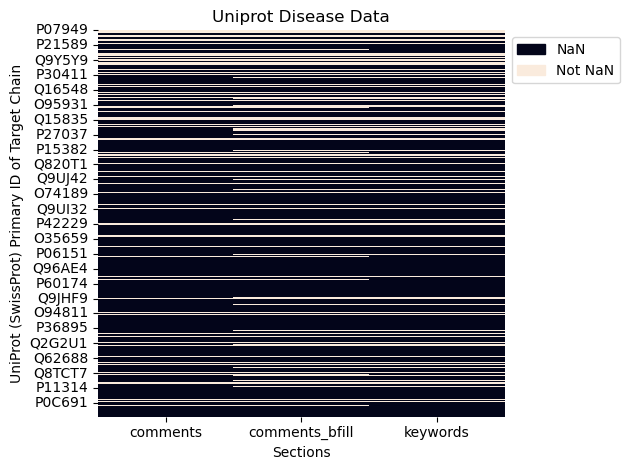

In [21]:
fig, ax = plt.subplots()

cmap = sns.color_palette("rocket", as_cmap=True)

sns.heatmap(
    diseases_df[
        [
            "UniProt (SwissProt) Primary ID of Target Chain",
            "comments",
            "comments_bfill",
            "keywords",
        ]
    ]
    .set_index("UniProt (SwissProt) Primary ID of Target Chain")
    .notna(),
    ax=ax,
    cbar=False,
    cmap=cmap,
)

isna_patch = mpatches.Patch(color=cmap.get_under(), label="NaN")
notna_patch = mpatches.Patch(color=cmap.get_over(), label="Not NaN")

ax.legend(title="", handles=[isna_patch, notna_patch])
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_xlabel("Sections")

ax.set_title("Uniprot Disease Data")

plt.tight_layout()
plt.show()

With this data we can now plot the frequency of studied diseases. We group the diseases into different classes using the `sort_diseases` function, based on common names and terminologies. We then show the distribution of targeted diseases.

In [22]:
diseases_df = diseases_df.rename(columns={"comments_bfill": "diseases"})
diseases_df = diseases_df.dropna(subset="diseases").drop(
    columns=["comments", "keywords"]
)
diseases_df["Disease Classes"] = diseases_df["diseases"].apply(
    lambda l: [sort_diseases(l_i) for l_i in l]
)

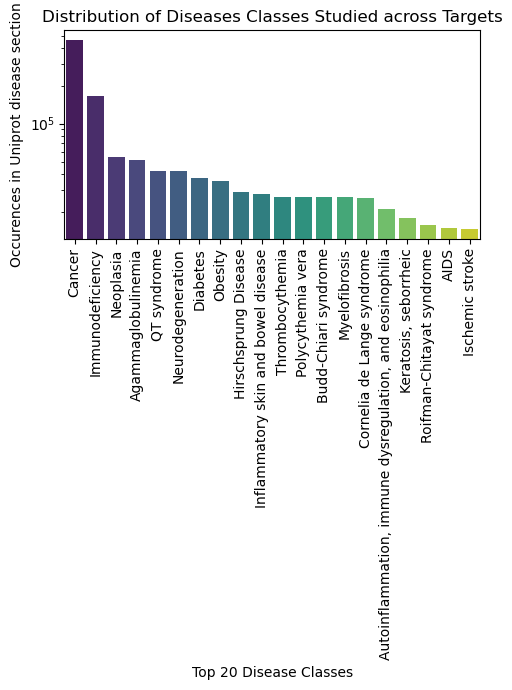

In [23]:
df_intersection_disease_class_counts = (
    bindingdb_df.merge(diseases_df, how="inner")
    .explode(["Disease Classes", "diseases"])
    .value_counts(subset=["Disease Classes"])
    .reset_index()
)

fig, ax = plt.subplots(figsize=(5, 7))

sns.barplot(
    data=df_intersection_disease_class_counts,
    x="Disease Classes",
    y="count",
    order=df_intersection_disease_class_counts["Disease Classes"][:20],
    # hue="count",
    legend=None,
    palette="viridis",
    ax=ax,
)

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_xlabel("Top 20 " + ax.get_xlabel())
ax.set_yscale("log")
ax.set_ylabel("Occurences in Uniprot disease section")
ax.set_title("Distribution of Diseases Classes Studied across Targets")

plt.tight_layout()
plt.show()

In the above plot, we observe that `Cancer`, which regroups all kinds of different cancers, is the most studied disease class. `Neurodegeneration` which regroups diseases such as `Parkinson` and `Alzheimer` is 5th. The sexually transmitted disease of `AIDS` is also within the top 20, recalling its importance in targeted organisms. 

We now load the `src/data/metadata.csv` file which was generated using the following script in roughly 5 hours:

```py
from src.scripts.metadata import add_extra_pub_data
import pandas as pd
df = pd.read_csv(
    r"./data/BindingDB_All.tsv",
    sep="\t",
    usecols=["Article DOI"],
)
add_extra_pub_data(df)
```

This function uses a `crossref` API call to collect additional metadata from publications, such as year, publisher and more.

In [24]:
doi_metadata = pd.read_csv(r"src/data/metadata.csv").dropna()
doi_metadata.describe(include="all").fillna("")

Article DOI                         journal         year  \
count               40719                           40719      40719.0   
unique              40719                             195                
top     10.1021/jm9602571  Journal of Medicinal Chemistry                
freq                    1                           13877                
mean                                                       2008.964709   
std                                                           8.519787   
min                                                             1965.0   
25%                                                             2004.0   
50%                                                             2010.0   
75%                                                             2016.0   
max                                                             2022.0   

          publisher  
count         40719  
unique           33  
top     Elsevier BV  
freq          21918  
mean                 
std                  
min                  
25%                  
50%                  
75%                  
max

From the `crossref` API, we collected the `journal`, the `year` and the `publisher` related to the `Article DOI`. We can see that there are 195 unique journals, and 33 different publishers. With the year, we can now correlate the frequency of diseases studied with time.

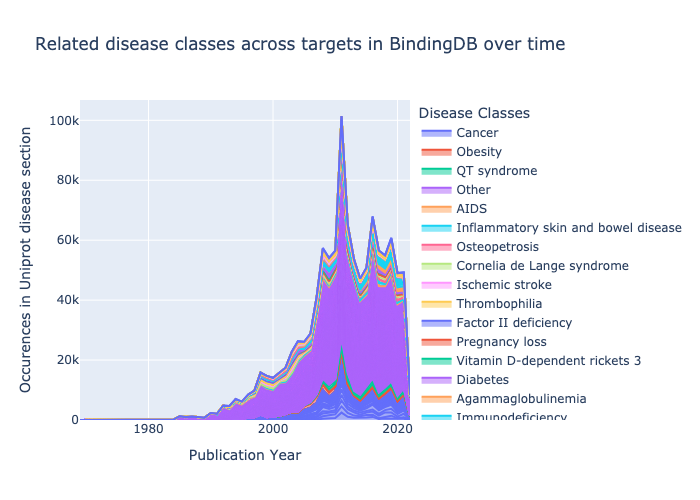

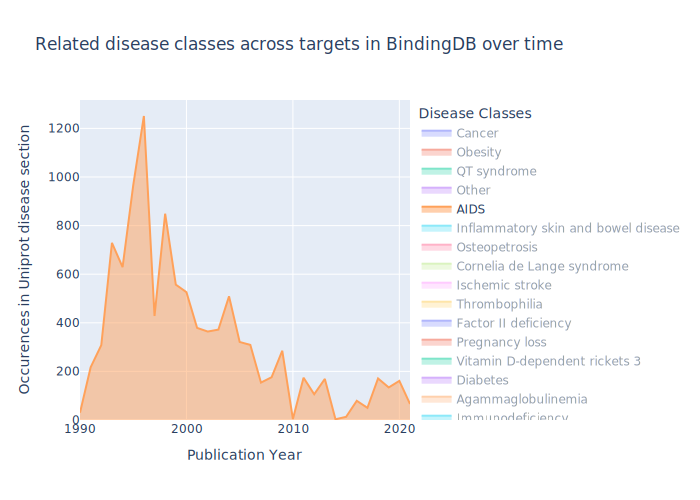

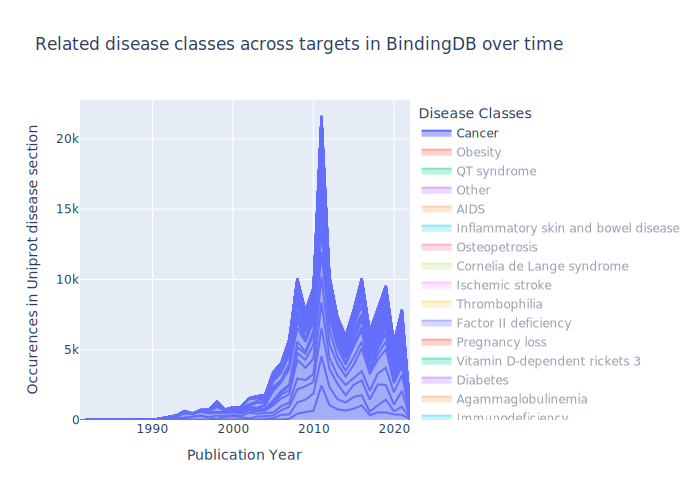

In [25]:
time_series_diseases_df = (
    bindingdb_df.dropna()
    .merge(diseases_df.dropna(), how="inner")
    .merge(doi_metadata.dropna(), how="inner")
)

time_series_diseases_df_count = (
    time_series_diseases_df.explode(["Disease Classes", "diseases"])
    .value_counts(subset=["year", "Disease Classes", "diseases"])
    .reset_index()
)
time_series_diseases_df_count["Disease Classes"] = time_series_diseases_df_count[
    "Disease Classes"
].replace(
    {
        k: "Other"
        for k in time_series_diseases_df.explode(["Disease Classes"])["Disease Classes"]
        .value_counts()
        .index[20:]
    }
)

fig = px.area(
    time_series_diseases_df_count,
    x="year",
    y="count",
    color="Disease Classes",
    line_group="diseases",
    labels={
        "count": "Occurences in Uniprot disease section",
        "year": "Publication Year",
    },
    title="Related disease classes across targets in BindingDB over time",
)
# fig.show() # Uncomment this line to view the figure interactively

fig.show(
    renderer="png"
)  # Low quality rendenring otherwise it slows the notebook too much

fig.for_each_trace(
    lambda t: t.update(visible=True)
    if t["legendgroup"] == "AIDS"
    else t.update(visible="legendonly")
)
fig.show(renderer="svg")

fig.for_each_trace(
    lambda t: t.update(visible=True)
    if t["legendgroup"] == "Cancer"
    else t.update(visible="legendonly")
)
fig.show(renderer="svg")

In the above plots, each line represents a single disease, while shades of colors represent the disease class. By interacting with this plot, we observe that `AIDS` was studied more during the 90's, peaked in 1996, and decreased ever since. This is highly likely due to the 1980s [AIDS pandemic](https://en.wikipedia.org/wiki/Epidemiology_of_HIV/AIDS). On the other hand, proteins related to cancer started to become more popular around 2004, peaked in 2011 where more specifically `Hepatocellular Carcinoma` was the most studied.

If we look at the data as a whole, we can see three peaks above 60k mentions, which are in 2011, in 2016 and in 2019, possibly reflecting the addition of new curations to BindingDB.

# Success metrics: Citations

To gain a more comprehensive understanding of how research focus on various disease classes has evolved over time, we are now interested in analyzing citations trends. From the `crossref` API, we are able to retrieve the number of times each `Article DOI` was cited. This gives us an idea of its importance and influence in a specific research field.

We now load the `src/data/citations.json` file which was generated using the following script:

```py
from src.scripts.citations import get_citations

doi = df["Article DOI"].value_counts()
unique_doi_ordered = doi.index.tolist()
citations = []
for doi in unique_doi_ordered:
    citation = get_citations(doi)
    citations.append({"doi": doi, "citation": citation})
with open("citations.json", "w") as f:
    json.dump(citations, f)
```

The function `get_citations` uses the `crossref` API call to get the number of citations based on an Article DOI.

In [26]:
with open("src/data/citations.json", "r") as f:
    citations = json.load(f)

In the plot below, we visualize the citation count of the 100 most frequently cited articles in BindingDB.

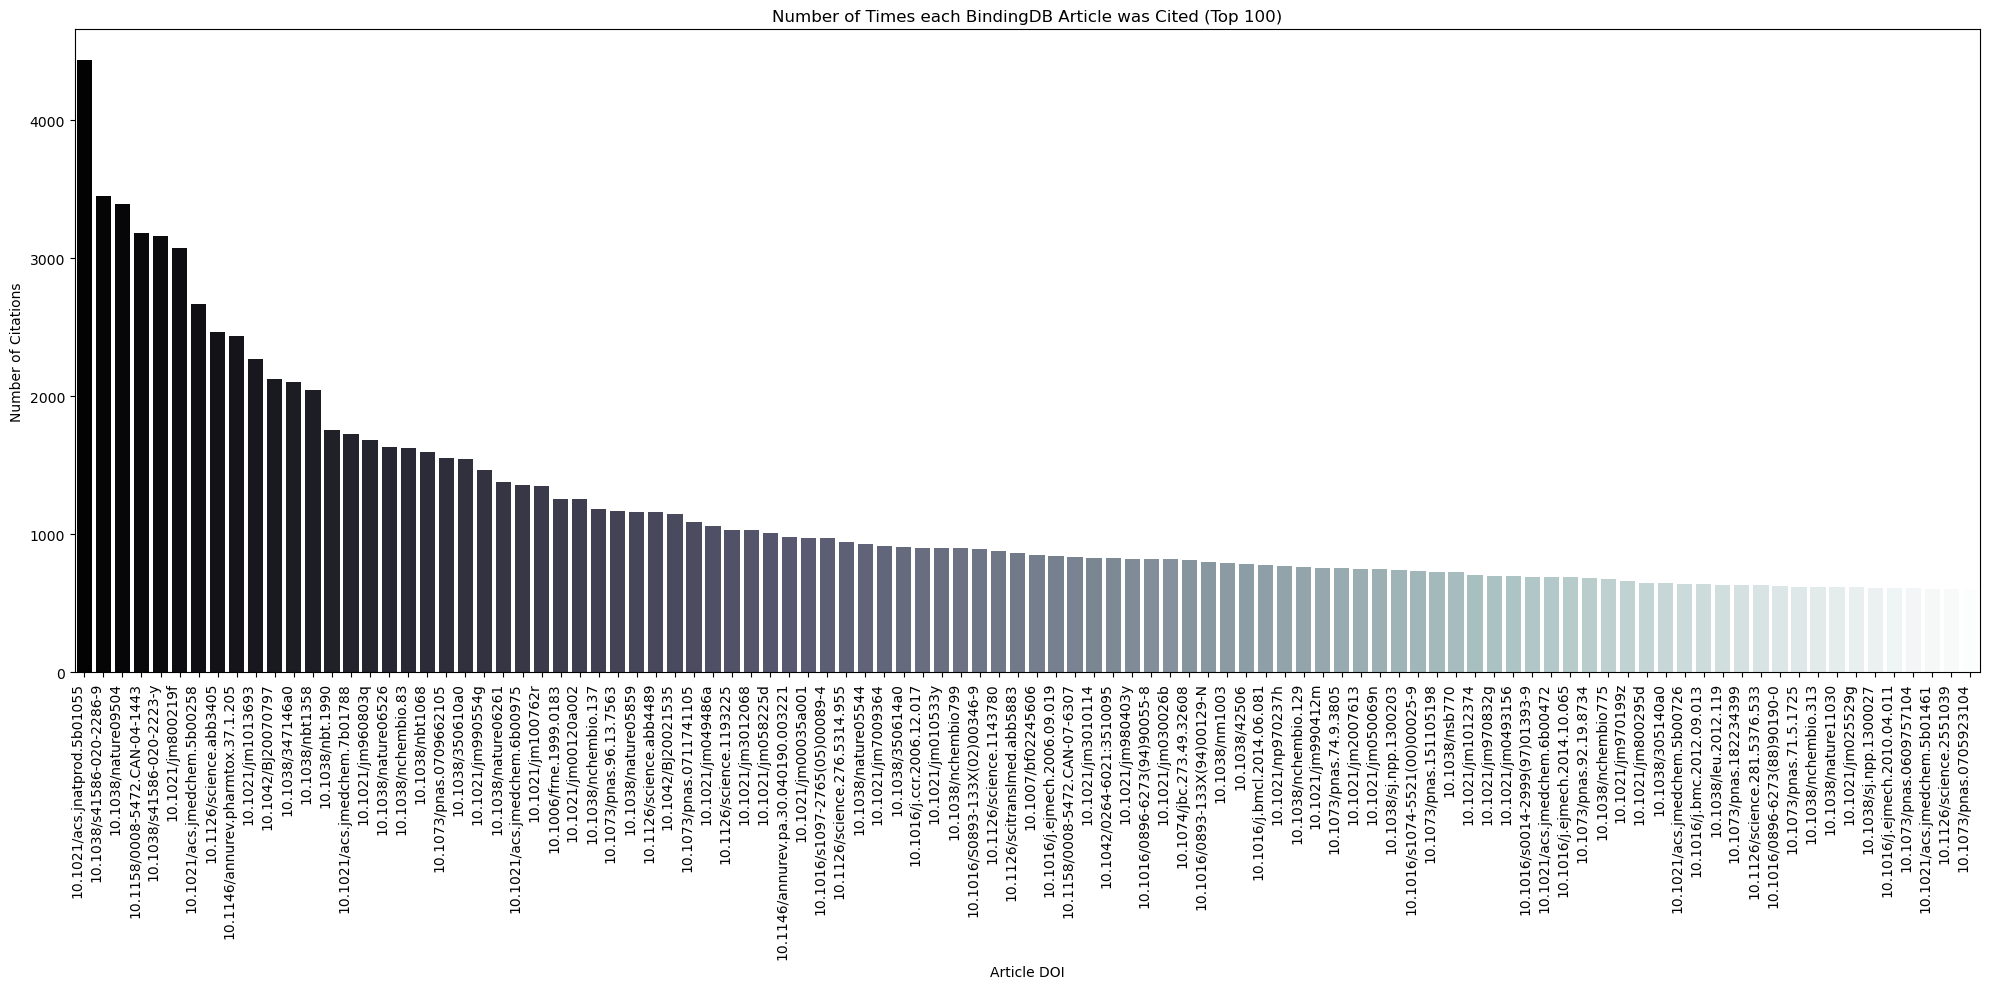

In [27]:
citations_df = (
    pd.DataFrame(citations).sort_values(by="citation", ascending=False).head(100)
)
plt.figure(figsize=(20, 10))
sns.barplot(x="doi", y="citation", data=citations_df, palette="bone")
plt.xticks(rotation=90, ha="right")
plt.xlabel("Article DOI")
plt.ylabel("Number of Citations")
plt.title("Number of Times each BindingDB Article was Cited (Top 100)")
plt.tight_layout()
plt.show()

To gain a deeper understanding of the influence of these articles, we are now interested in looking at citations trends for different disease classes. Indeed, we suspect this seperation to be more informative than the overall distribution of citations.

In [28]:
from src.scripts.citations import get_citations_per_disease

citations_dict = {item["doi"]: item["citation"] for item in citations}
disease_citations_df = get_citations_per_disease(df, diseases_df, citations_dict)

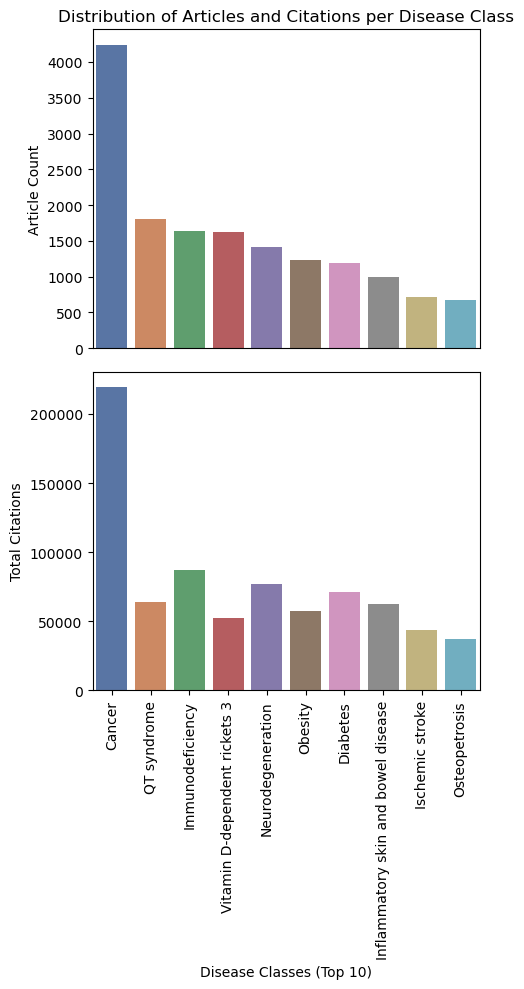

In [29]:
fig, axes = plt.subplots(2, 1, figsize=(5, 10), sharex=True)
sns.barplot(
    data=disease_citations_df[0:10],
    x="Disease Classes",
    y="Article Count",
    palette="deep",
    ax=axes[0],
)
axes[0].set_title("Distribution of Articles and Citations per Disease Class")
axes[0].tick_params(axis="x", which="both", bottom=False)

sns.barplot(
    data=disease_citations_df.head(10),
    x="Disease Classes",
    y="Total Citations",
    palette="deep",
    ax=axes[1],
)
axes[1].set_xlabel("Disease Classes (Top 10)")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)


plt.tight_layout()
plt.show()

As expected, cancer has the highest article count as well as total citations count. Interestingly, we notice that having a higher article count does not necessarily mean a higher citation count. For instance, there are fewer articles investigating immunodeficiency compared to QT syndrome, however immunodeficiency is more cited.

This highlights the need for an additional metric to assess the importance and "success" of a disease class based on its citations.

One approach could be to look at the mean number of citations per article for each disease class. However, this only provides an average that may not reflect the true impact of a disease class on research focus, especially when there are a few highly-cited articles that skew the mean.

A second approach and more robust metric for assessing the impact and "success" could be to use the h-index. This metric is usually used as an indicator of a researcher's influence in his field. Precisely, a researcher has a h-index of h if h of their papers have at least h citations each, and the remaining papers have ≤h citations. Thus, this metric could be a better indicator of scholarly contribution and impact of a given field of research, by transfering the metric from authors to specific classes. By calculating the h-index for each disease class, we want to account for both the quantity and the citation strength of the work.

In [30]:
# Mean Citation per Article :
disease_citations_df["Mean Citation per Article"] = (
    disease_citations_df["Total Citations"] / disease_citations_df["Article Count"]
)

# H-index calculation :
from src.scripts.citations import calculate_H_index

disease_h_index_df = calculate_H_index(disease_citations_df, citations_dict)

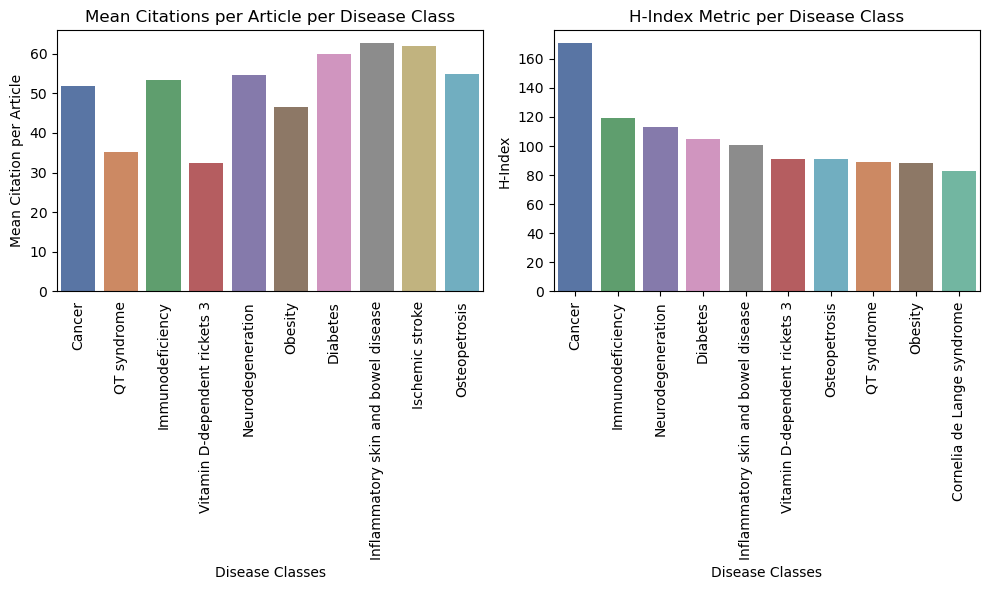

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
sns.barplot(
    data=disease_citations_df.head(10),
    x="Disease Classes",
    y="Mean Citation per Article",
    palette="deep",
    ax=axes[0],
)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
axes[0].set_title("Mean Citations per Article per Disease Class")
axes[0].tick_params(axis="x", which="both", bottom=False)

# Adapting color palette for second plot so it matches the first (same diseases have same color)
deep_palette = sns.color_palette("deep", len(disease_citations_df.head(10)))
color_mapping = dict(
    zip(disease_citations_df.head(10)["Disease Classes"], deep_palette)
)
adapted_palette = []
for disease_class in disease_h_index_df.head(10)["Disease Classes"]:
    if disease_class in color_mapping:
        adapted_palette.append(color_mapping[disease_class])
    else:
        adapted_palette.append(sns.color_palette("Set2", 1)[0])

sns.barplot(
    data=disease_h_index_df.head(10),
    x="Disease Classes",
    y="H-Index",
    palette=adapted_palette,
    ax=axes[1],
)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)
axes[1].set_title("H-Index Metric per Disease Class")

plt.tight_layout()
plt.show()

As expected, the mean number of citations per article is less indicative to measure the importance of a particular disease class. Cancer, for instance, only has a mean number of citations per article of 52, even though this disease class has the highest number of both articles and citations. However, cancer shows the highest h-index. 

The high h-index of immunodeficiency research highlights the metric's ability to capture both the volume and impact of the work. Indeed, this disease class ranks third in article count but has the second-highest total citation count.

To get a deeper understanding of citations and research focus for each disease class, we are also interested in analyzing these trends over time. Below, we compute and plot the total number of citations each disease class has received over the years.

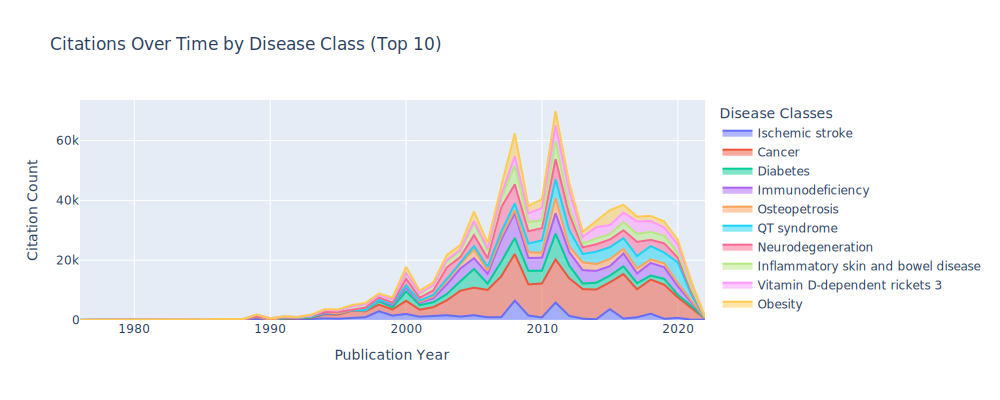

In [32]:
from src.scripts.citations import get_citations_per_year_diseases

citations_time_diseases = get_citations_per_year_diseases(
    disease_citations_df, citations_dict
)
fig = px.area(
    citations_time_diseases,
    x="Year",
    y="Citations",
    color="Disease Classes",
    line_group="Disease Classes",
    title="Citations Over Time by Disease Class (Top 10)",
    labels={"Year": "Publication Year", "Citations": "Citation Count"},
)
fig.update_layout(height=400, width=1000)
# fig.show() # Uncomment this line to view the figure interactively

fig.show(renderer="svg")

### Patents Citations

As mentioned previously, key metrics of success are taken from the number of citations of an article or patent, and these metrics are complementary within BindingDB. We previously investigated article citations and how they are linked to disease classes. Here, we show that patent information is obtainable and how to retrieve patent citations.

In [33]:
patents = df["Patent Number"].value_counts()
unique_patents_ordered = patents.index.tolist()

In [34]:
from src.scripts.citations import get_patent_info

patent_info = []
for patent in unique_patents_ordered[0:100]:
    patent_info.append(get_patent_info(patent))

The `get_patent_info` function uses google patents to retrieve the information of interest. 

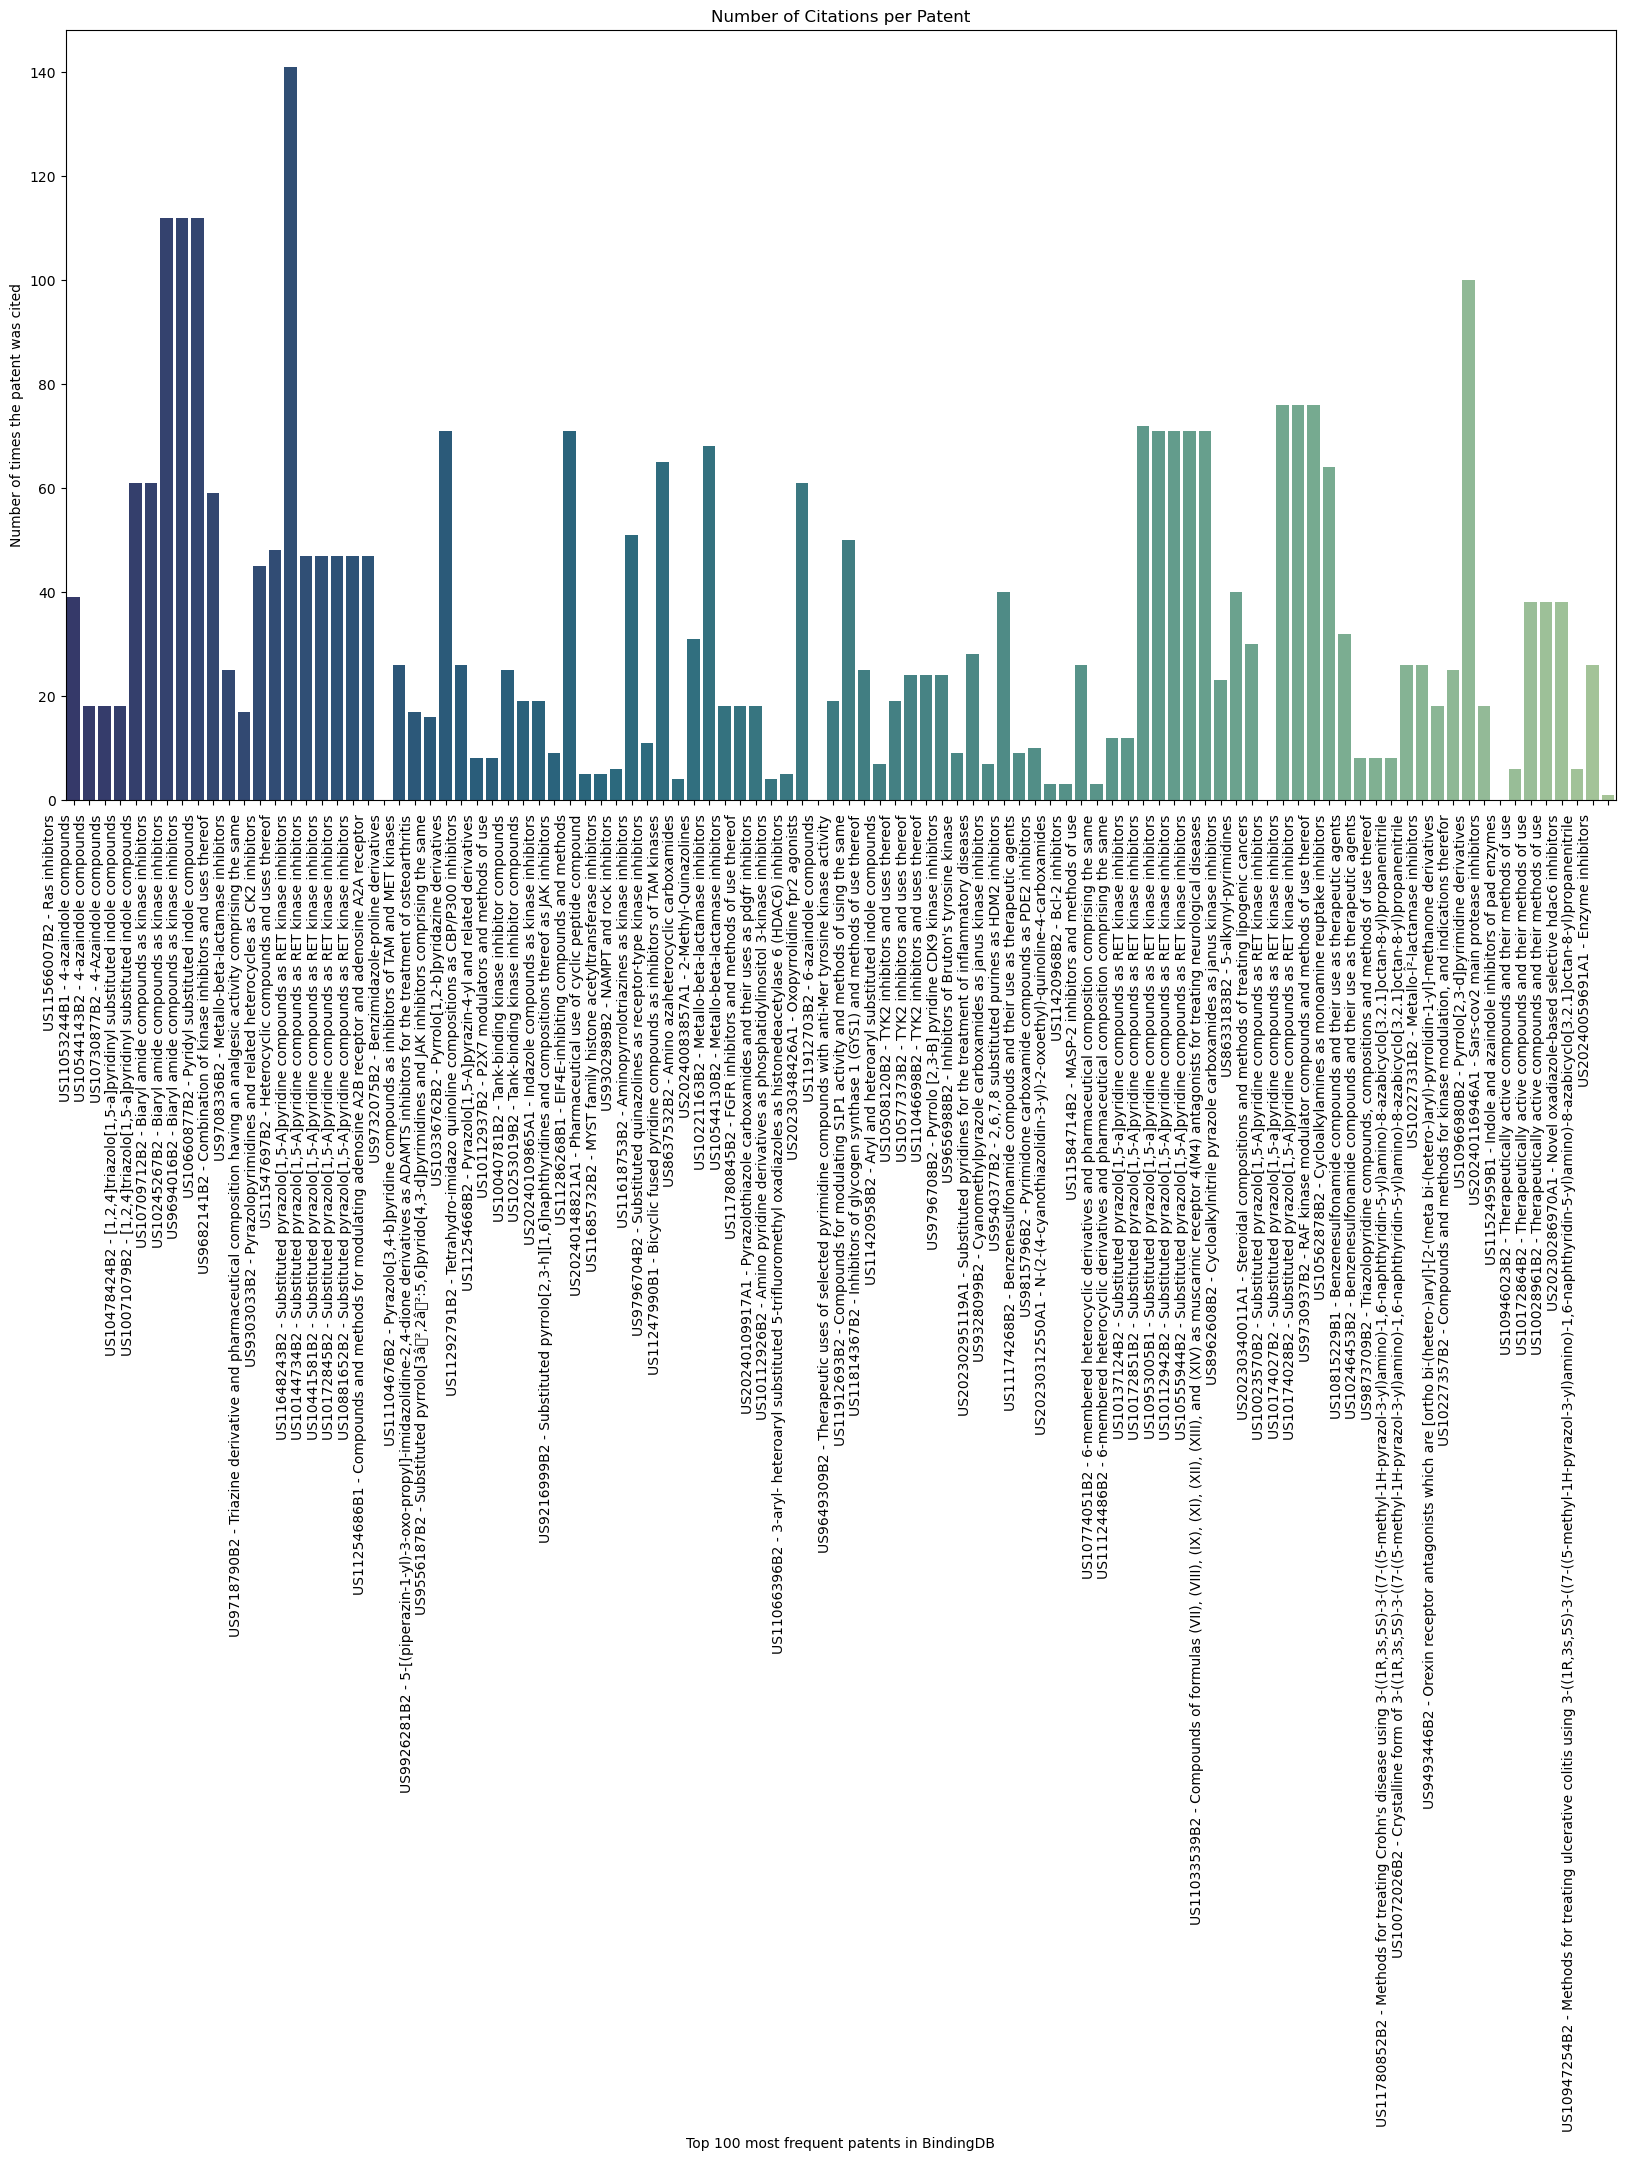

In [35]:
cleaned_patents = [patent for patent in patent_info if patent is not None]
citations = [
    int(patent["cited by"]) + int(patent["families citing"])
    for patent in cleaned_patents
    if "cited by" in patent and "families citing" in patent
]
patent_name = [
    patent["title"].replace(" - Google Patents", "")
    for patent in cleaned_patents
    if "title" in patent
]
data_citations = pd.DataFrame({"Patent": patent_name, "Cited By": citations})
plt.figure(figsize=(20, 10))
sns.barplot(x="Patent", y="Cited By", data=data_citations, palette="crest_r")
plt.title("Number of Citations per Patent")
plt.xlabel("Top 100 most frequent patents in BindingDB")
plt.ylabel("Number of times the patent was cited")
plt.xticks(rotation=90, ha="right")
plt.show()

---

# Target Protein Classification

On top of classifying diseases, we it is also necessary to classify ligands. Indeed, having these categories will help in accounting for confounding variables in future analyses, as well as focus on certain classes of interest. 

To do so, we first standardize the characters to lower case in the 'Target Name' field to improve browsing and searchability. Thereafter, we classify target proteins based on biological knowledge.

In [36]:
names_df = pd.read_csv(
    "data/BindingDB_All.tsv",
    sep="\t",
    usecols=[
        "UniProt (SwissProt) Recommended Name of Target Chain",
        "UniProt (TrEMBL) Submitted Name of Target Chain",
    ],
)

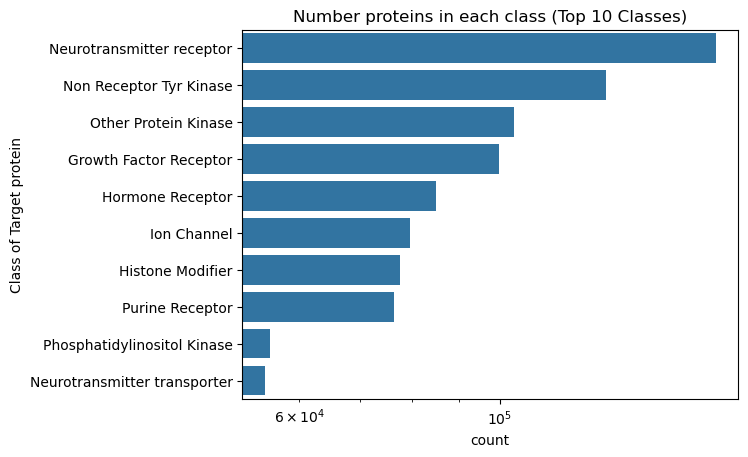

In [37]:
mapped_names = targets.get_target_class(names_df=names_df)
fig, ax = plt.subplots(1, 1)
plot_df = mapped_names.value_counts().reset_index()
sns.barplot(
    plot_df,
    y="UniProt (SwissProt) Recommended Name of Target Chain",
    x="count",
    order=plot_df.loc[:9, "UniProt (SwissProt) Recommended Name of Target Chain"],
    ax=ax,
)
ax.set_xscale("log")
ax.set_ylabel("Class of Target protein")
ax.set_title("Number proteins in each class (Top 10 Classes)")
plt.show()

As shown in the above figure, we observe main classes of target proteins with high counts within BindingDB.

**1. Neurotransmitter Receptor**
   - These are membrane proteins that mediate the action of neurotransmitters, which are chemicals that transmit signals in the nervous system.

**2. Non-Receptor Tyrosine Kinase**
   - These enzymes transfer phosphate groups to tyrosine residues on target proteins, playing crucial roles in cellular signaling. Unlike receptor tyrosine kinases, they are not embedded in the cell membrane.

**3. Other Protein Kinase**
   - This group includes various protein kinases other than tyrosine kinases, such as serine/threonine kinases, which are involved in a wide range of cellular processes.

**4. Growth Factor Receptor**
   - These receptors bind growth factors and activate signaling pathways that regulate cell growth, survival, and differentiation.

**5. Hormone Receptor**
   - These receptors respond to hormone molecules and regulate gene expression. They are usually located in the cell nucleus or on the cell surface.

**6. Ion Channel**
   - Ion channels are membrane proteins that allow the flow of ions (e.g., sodium, potassium, calcium) across the cell membrane, critical for neuronal signaling and muscle contraction.

**7. Histone Modifier**
   - These enzymes modify histones (proteins around which DNA is wound) and influence gene expression by altering chromatin structure. Common modifications include acetylation, methylation, and phosphorylation.

**8. Purine Receptor**
   - These are cell surface receptors that respond to purines like ATP, ADP, and adenosine, which are signaling molecules involved in energy transfer and metabolism.

**9. Phosphatidylinositol Kinase**
   - These kinases are involved in phosphoinositide metabolism and signaling, impacting various cellular processes including growth and survival.

**10. Neurotransmitter Transporter**
   - These are proteins responsible for the reuptake or transport of neurotransmitters across cell membranes, helping regulate neurotransmitter levels in synaptic clefts.

---

In [39]:
import pandas as pd
import numpy as np

from src.scripts import smiles
from src.scripts import targets
from src.utils import utils

%load_ext autoreload

# plotting tools
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import plotly.graph_objects as go
from matplotlib.patches import Patch

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import linkage, dendrogram

# rdkit tools
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs, Descriptors, Draw

# Taxonomy
from ete3 import NCBITaxa

import pandas as pd
import json
from tqdm import tqdm
import seaborn as sns


from sklearn.cluster import DBSCAN

# Molecular and Chemical Features

In [40]:
mol_df = (
    pd.read_csv(
        "data/BindingDB_All.tsv",
        sep="\t",
        usecols=[
            "BindingDB Reactant_set_id",
            "Ligand SMILES",
            "BindingDB Ligand Name",
        ],
    )
    .dropna()
    .sample(10000, random_state=0)
)
mol_df.head()

BindingDB Reactant_set_id  \
710434                      726690   
1663970                   50281492   
544012                      555691   
280988                      281011   
300927                      300950   

                                             Ligand SMILES  \
710434   NS(=O)(=O)c1c(ccc(-c2ccc(O)nc2)c1-c1nnn[nH]1)S...   
1663970  CO[C@@H]1C[C@H](N(C1)C(=O)NCc1ccc(cc1Cl)C(=O)N...   
544012   Nc1ncnc2n(nc(C(=O)Nc3nc4cc(F)ccc4o3)c12)[C@@H]...   
280988               Cc1ncncc1-c1ccnc2c(csc12)-c1ccc(F)cc1   
300927          NC(=O)c1ccc(cc1)C1CC1C(=O)N1CCN(CC1)C1CCC1   

                                     BindingDB Ligand Name  
710434   3-((4-(6-hydroxypyridin- 3-yl)-2-sulfamoyl-3-(...  
1663970  (2S,4R)-4-Methoxy-2-(4-methyl-[1,4]diazepane-1...  
544012                               US9580432, Example 12  
280988                        US8969586, 98::US9598436, 98  
300927         US9029381, 42::US9029381, 43::US9029381, 44

## Chemical Properties

[17:31:27] Can't kekulize mol.  Unkekulized atoms: 1 2 6
[17:31:27] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 15 16
[17:31:28] Explicit valence for atom # 30 N, 4, is greater than permitted
[17:31:28] Explicit valence for atom # 15 N, 4, is greater than permitted
[17:31:28] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[17:31:29] Explicit valence for atom # 17 O, 3, is greater than permitted
[17:31:29] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
[17:31:29] Explicit valence for atom # 32 N, 4, is greater than permitted
[17:31:29] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29 30 32 33 34
[17:31:29] Explicit valence for atom # 29 N, 4, is greater than permitted
[17:31:30] Can't kekulize mol.  Unkekulized atoms: 1 2 6
[17:31:30] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 15 16
[17:31:30] Explicit valence for atom # 30 N, 4, is greater than permitted
[17:31:31] Explicit valence for atom # 15 N, 4, is greater than permitted
[17:31:

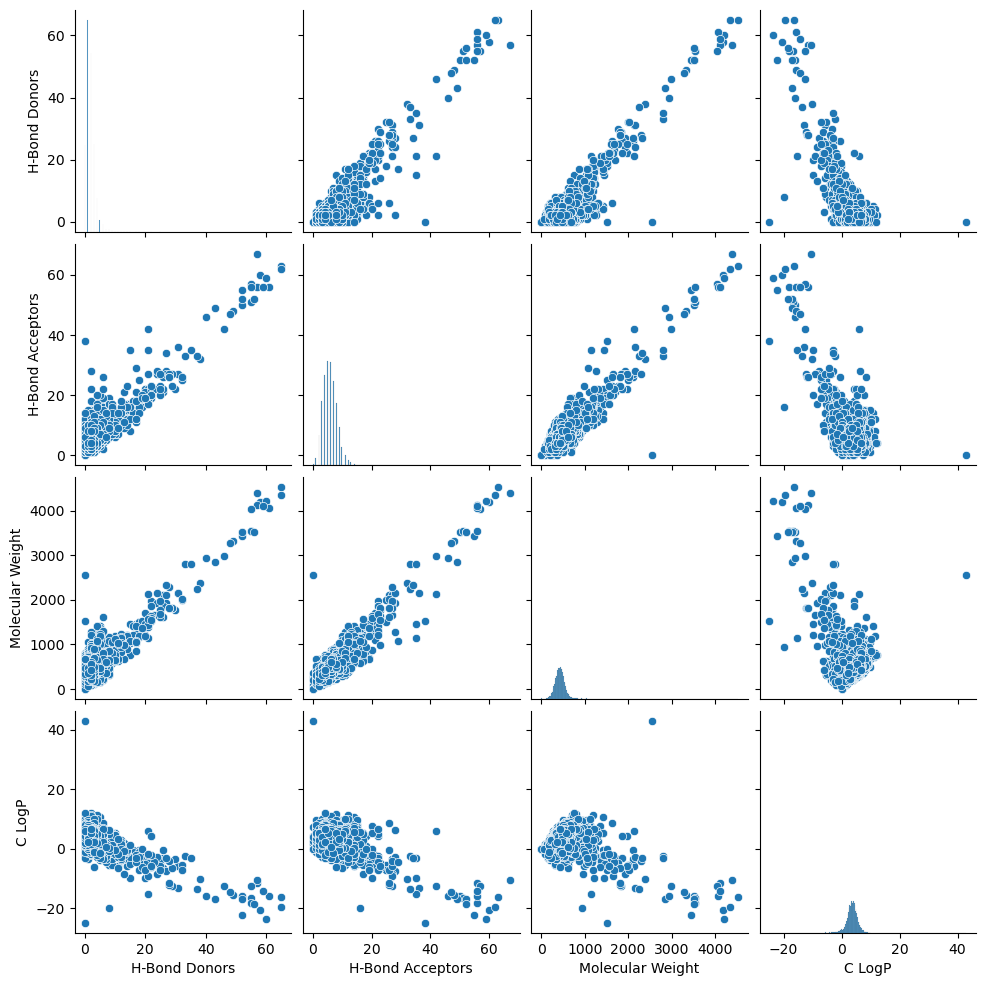

In [41]:
mol_df["H-Bond Donors"] = mol_df["Ligand SMILES"].apply(smiles.get_Hdonors)
mol_df["H-Bond Acceptors"] = mol_df["Ligand SMILES"].apply(smiles.get_Hacceptors)
mol_df["Molecular Weight"] = mol_df["Ligand SMILES"].apply(smiles.get_MW)
mol_df["C LogP"] = mol_df["Ligand SMILES"].apply(smiles.get_LogP)
sns.pairplot(
    mol_df, vars=["H-Bond Donors", "H-Bond Acceptors", "Molecular Weight", "C LogP"]
)

The scatter plot matrix (or pair plot) in this analysis visualizes the relationships between four molecular properties: H-Bond Donors, H-Bond Acceptors, Molecular Weight, and C LogP for a set of ligands.

We explain here these variables:
- H-Bond Donors: Number of hydrogen bond donor sites on the molecule.
- H-Bond Acceptors: Number of hydrogen bond acceptor sites.
- Molecular Weight: The molecular weight of each molecule.
- C LogP: The calculated partition coefficient (logarithm of the ratio of a compound's concentration in octanol vs. water), which is an indicator of hydrophobicity.
Interpretation and Observations:

**H-Bond Donors/Acceptors vs. Molecular Weight**: Both H-Bond Donors and H-Bond Acceptors show a strong positive correlation with Molecular Weight. This suggests that as the molecular weight increases, the molecule tends to have more sites for hydrogen bonding, likely due to increased molecular complexity.

**H-Bond Donors vs. H-Bond Acceptors**: The plot shows a positive correlation between H-Bond Donors and H-Bond Acceptors. Molecules with a high number of donor sites tend to also have a high number of acceptor sites. This is logical, as larger or more complex molecules often have both types of functional groups.

**H-Bond Donors/Acceptors vs. C LogP**: There appears to be a weak to moderate inverse relationship between both hydrogen bond donors/acceptors and C LogP. Molecules with higher hydrogen bonding capabilities (more H-Bond Donors/Acceptors) tend to be more hydrophilic, which is reflected in lower C LogP values (indicating lower lipophilicity).

**Molecular Weight vs. C LogP**: This relationship is more dispersed. Higher molecular weight molecules do not necessarily have a consistent C LogP trend, but there appears to be a wider range of lipophilicity in larger molecules. This variability could be due to the diversity in functional groups or molecular structures within the sample.

This analysis highlights some expected relationships between molecular properties. Indeed, molecules with more complex structures (higher molecular weight) are likely to have more hydrogen bond donors and acceptors, suggesting a greater potential for interactions through hydrogen bonding.
The inverse relationship between hydrogen bonding capabilities and C LogP is in line with the typical properties of hydrophilic and lipophilic compounds, where molecules with more hydrogen bonding sites are generally less lipophilic.

Overall, this exploratory visualization can help identify potential clustering or trends within the dataset, which can be useful in understanding molecular behavior, predicting solubility, permeability, or guiding structure-activity relationship (SAR) analysis in drug discovery.

## Lipinski's Rule
Lipinski's rule of five is a rule of thumb to evaluate drug likeness or determine if a chemical compound with a certain pharmacological or biological activity has chemical properties and physical properties that would likely make it an orally active drug in humans. The 
- No more than 5 H bonds donors
- No more than 10 H bond acceptors
- A molecular mass less than 500 Daltons
- A calculated octanol-water partition coefficient (Clog P) that does not exceed 5

[17:31:46] Can't kekulize mol.  Unkekulized atoms: 1 2 6


Invalid SMILES string.


[17:31:47] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 15 16


Invalid SMILES string.


[17:31:47] Explicit valence for atom # 30 N, 4, is greater than permitted


Invalid SMILES string.


[17:31:50] Explicit valence for atom # 15 N, 4, is greater than permitted


Invalid SMILES string.


[17:31:51] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13


Invalid SMILES string.


[17:31:51] Explicit valence for atom # 17 O, 3, is greater than permitted


Invalid SMILES string.


[17:31:52] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24


Invalid SMILES string.


[17:31:52] Explicit valence for atom # 32 N, 4, is greater than permitted


Invalid SMILES string.


[17:31:53] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29 30 32 33 34
[17:31:54] Explicit valence for atom # 29 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


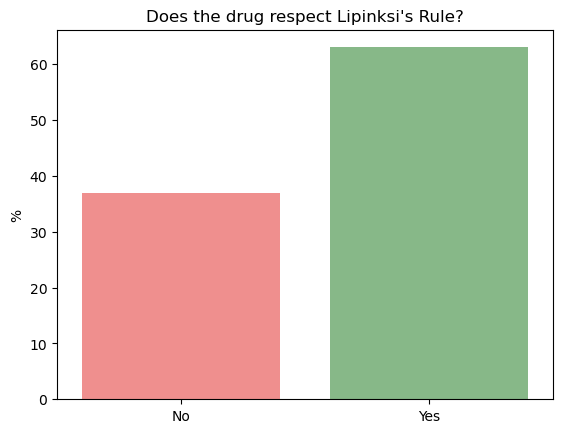

In [42]:
mol_df["Lipinski"] = mol_df["Ligand SMILES"].apply(smiles.lipinski)
ax = sns.countplot(
    mol_df,
    x="Lipinski",
    stat="percent",
    hue="Lipinski",
    palette=["#ff7f7e", "#7fc080"],
    legend=False,
)
ax.set_title("Does the drug respect Lipinksi's Rule?")
ax.set_xticklabels(["No", "Yes"])
ax.set_xlabel("")
ax.set_ylabel("%")
plt.show()

We observe a majority of drugs that respect Lipinski's rule. There are many other similar rules for drug likeness, such as Ghose filter, Veber's Rule... Other chemical properties such as number of rotatable bonds and polar surface area have been shown to influence oral bioavailability. Further analysis of the chemical features could revolve around looking into these features and rules and determining their relationship to the success metrics.

## Molecular Fingerprints

In [43]:
mol_df["Ligand Fingerprint"] = mol_df["Ligand SMILES"].apply(smiles.get_fingerprint)

[17:31:55] Can't kekulize mol.  Unkekulized atoms: 1 2 6
[17:31:55] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 15 16
[17:31:55] Explicit valence for atom # 30 N, 4, is greater than permitted
[17:31:57] Explicit valence for atom # 15 N, 4, is greater than permitted
[17:31:57] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[17:31:57] Explicit valence for atom # 17 O, 3, is greater than permitted
[17:31:57] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
[17:31:58] Explicit valence for atom # 32 N, 4, is greater than permitted
[17:31:58] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29 30 32 33 34
[17:31:58] Explicit valence for atom # 29 N, 4, is greater than permitted


A molecular fingerprint is a representation of a molecule in a digital form that allows for easy comparison with other molecules. Fingerprints capture structural information about a molecule, such as the presence of particular atoms, bonds, and functional groups, and transform this information into a series of binary values (bits) or numbers. We are using a Morgan fingerprint, a sparse 2048 bit encoding, generated using rdkit. Using the fingerprints we can perform clustering, measure distance, and train ML models.

### Clustering

In [44]:
smiles_df = pd.read_csv(
    "data/BindingDB_All.tsv",
    sep="\t",
    usecols=[
        "UniProt (SwissProt) Primary ID of Target Chain",
        "DrugBank ID of Ligand",
        "Ligand SMILES",
        "IC50 (nM)",
        "Article DOI",
    ],
)
target = smiles_df[
    smiles_df["UniProt (SwissProt) Primary ID of Target Chain"] == "P07949"
].dropna(subset=["Ligand SMILES", "IC50 (nM)"])
target["IC50 (nM)"] = (
    target["IC50 (nM)"]
    .astype(str)
    .str.replace(">", "")
    .str.replace("<", "")
    .astype(float)
)
smiles_df[
    "UniProt (SwissProt) Primary ID of Target Chain"
].dropna().value_counts().head()

UniProt (SwissProt) Primary ID of Target Chain
P07949    26807
O60674    25991
P00533    24060
Q06187    23249
O60885    21409
Name: count, dtype: int64

At this point of the project we use fingerprints for clustering. We focus on the highest occurring target in BindingDB; Uniprot ID: P07949. It corresponds to the Proto-oncogene tyrosine-protein kinase receptor Ret.



In [45]:
target["Ligand Fingerprint"] = target["Ligand SMILES"].apply(smiles.get_fingerprint)
target = target.dropna(subset="Ligand Fingerprint")
pca = PCA(n_components=3, random_state=0).fit(
    np.stack(target["Ligand Fingerprint"].dropna())
)
pca_coords = pca.transform(np.stack(target["Ligand Fingerprint"].dropna()))
target[["PC1", "PC2", "PC3"]] = pca_coords

[17:32:27] Explicit valence for atom # 1 N, 4, is greater than permitted
[17:32:29] Explicit valence for atom # 35 N, 4, is greater than permitted
[17:32:29] Explicit valence for atom # 35 N, 4, is greater than permitted
[17:32:30] Explicit valence for atom # 11 N, 4, is greater than permitted
[17:32:30] Explicit valence for atom # 11 N, 4, is greater than permitted
[17:32:33] Explicit valence for atom # 1 N, 4, is greater than permitted
[17:32:34] Can't kekulize mol.  Unkekulized atoms: 3 4 7 8 9
[17:32:34] Can't kekulize mol.  Unkekulized atoms: 3 4 7 8 9
[17:32:36] Explicit valence for atom # 17 N, 4, is greater than permitted
[17:32:36] Explicit valence for atom # 17 N, 4, is greater than permitted
[17:32:36] Explicit valence for atom # 17 N, 4, is greater than permitted


In [46]:
kmeans = KMeans(n_clusters=5, random_state=0, n_init="auto").fit(
    np.stack(target["Ligand Fingerprint"].dropna())
)
target["Cluster"] = kmeans.predict(np.stack(target["Ligand Fingerprint"].dropna()))

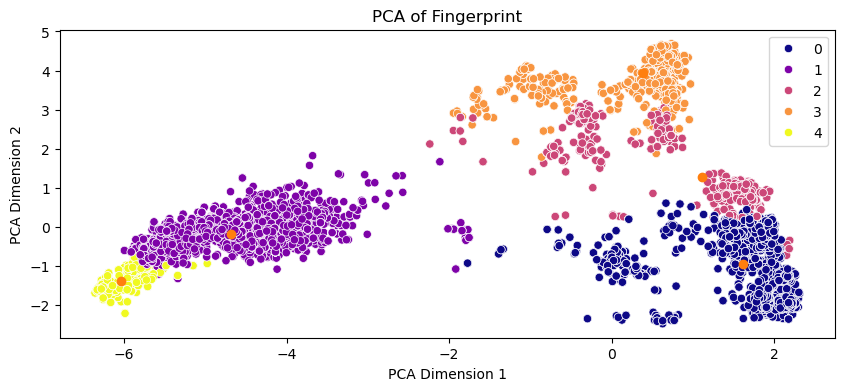

In [47]:
plt.figure(figsize=(10, 4))
sns.scatterplot(data=target, x="PC1", y="PC2", hue="Cluster", palette="plasma")
centroids = pca.transform(kmeans.cluster_centers_)
plt.scatter(x=centroids[:, 0], y=centroids[:, 1])
plt.title("PCA of Fingerprint")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.legend()
plt.show()

To visually confirm the significance of clustering, we show below randomly sampled molecules from each cluster.

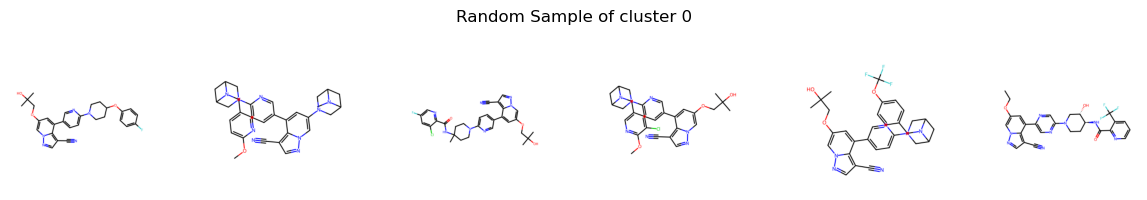

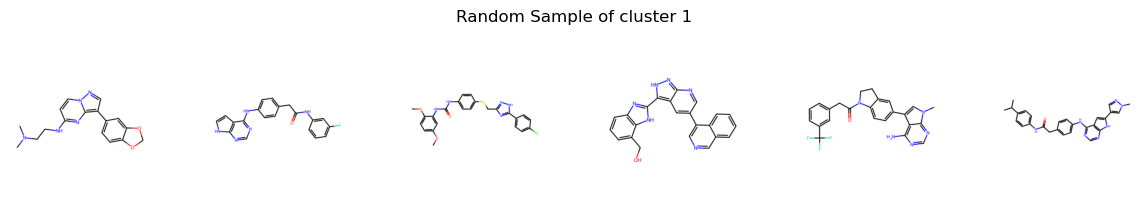

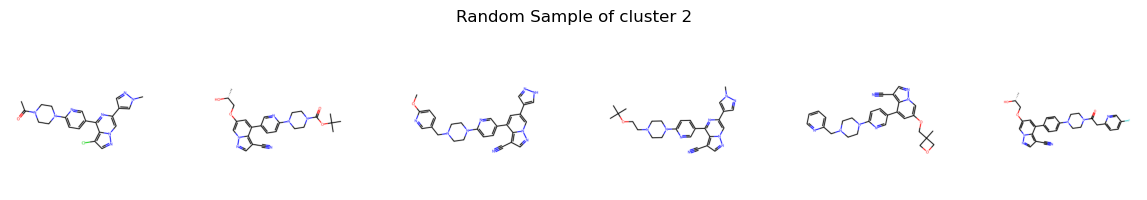

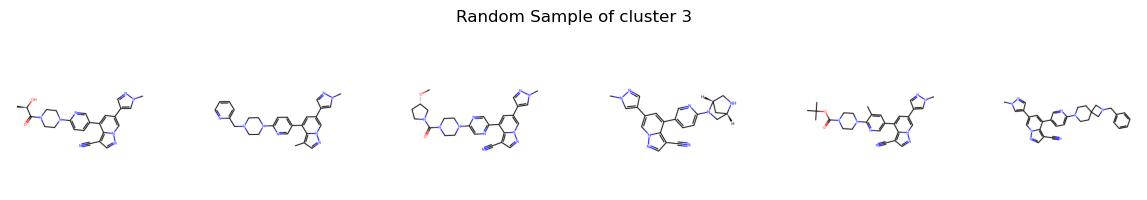

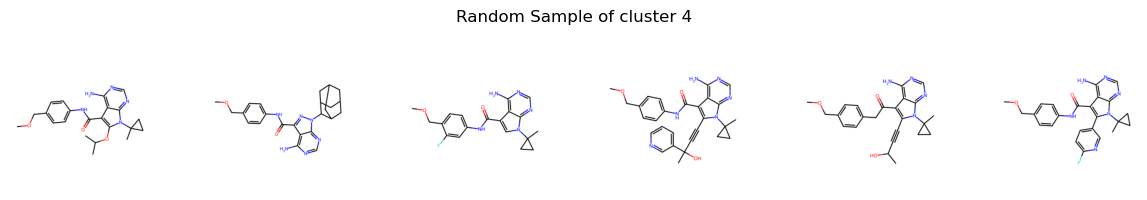

In [48]:
for i in range(5):
    smiles.show_smiles(
        target[target["Cluster"] == i],
        f"Random Sample of cluster {i}",
        n_rows=1,
        n_cols=6,
        random_sample=True,
    )

Finally, as a proof-of-concept of linking molecular features to success metrics, we show below a few of our success metrics overlayed on the previous molecular clustering.

In [50]:
prescriptions = pd.read_csv("src/data/prescription_per_drugbank_id.csv", index_col=0)
with open("src/data/citations.json", "r") as f:
    citations = json.load(f)
citations_df = pd.DataFrame(citations).sort_values(by="citation", ascending=False)

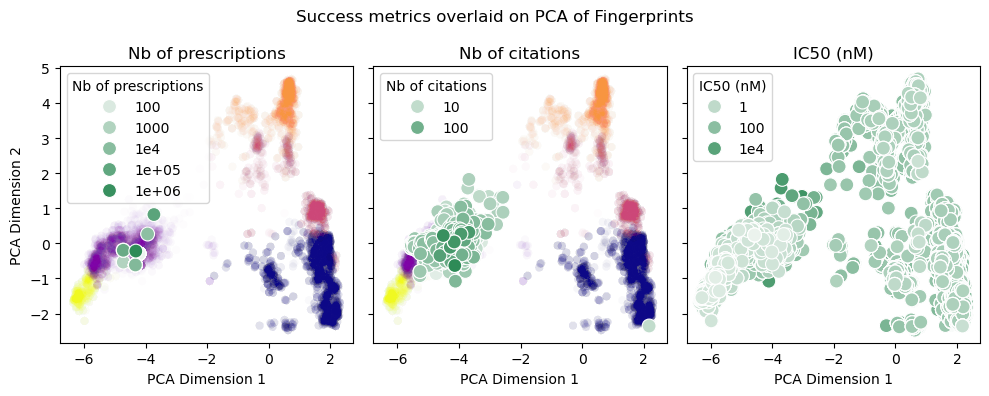

In [51]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharey=True)

for ax, data, hue, title in zip(
    axes,
    [
        pd.merge(
            target,
            prescriptions,
            left_on="DrugBank ID of Ligand",
            right_on="DrugBank ID of Ligand",
        ).sort_values("Number of Prescriptions"),
        pd.merge(
            target, citations_df, left_on="Article DOI", right_on="doi", how="inner"
        ).sort_values("citation"),
        target[target["IC50 (nM)"] != 0].sort_values("IC50 (nM)", ascending=False),
    ],
    ["Number of Prescriptions", "citation", "IC50 (nM)"],
    ["Nb of prescriptions", "Nb of citations", "IC50 (nM)"],
):
    sns.scatterplot(
        data=target,
        x="PC1",
        y="PC2",
        alpha=0.01,
        hue="Cluster",
        palette="plasma",
        legend=False,
        ax=ax,
    )  # Underlying clusters
    sns.scatterplot(
        data=data,
        x="PC1",
        y="PC2",
        hue=hue,
        hue_norm=mcolors.LogNorm(vmin=data[hue].min(), vmax=data[hue].max()),
        s=100,
        palette=sns.light_palette(
            "seagreen", as_cmap=True, reverse=False
        ),  # (hue=="IC50 (nM)")),
        ax=ax,
    )
    ax.get_legend().set_title(title)
    ax.set_title(title)
    ax.set_xlabel("PCA Dimension 1")
    ax.set_ylabel("PCA Dimension 2")
fig.suptitle("Success metrics overlaid on PCA of Fingerprints")
plt.tight_layout()
plt.show()

Interestingly, we observe that the overwhelming majority of drugs that score with success metrics are found within one cluster suggesting that the fingerprints encode some predictive traits for drug discovery. In the case of IC50 lower value means stronger inhibitor of target activity. Surprisingly the drugs that have the lowest IC50 (highest inhibition) are not the drugs that have the most citations. 

# Further Success Metrics
## Prescription Data

Using Medicaid, National Drug Code (NDC) Directory and Drugbank datasets, we map BindingDB entries to prescription and drug reimbursement data.

From BindingDB we have identifiers for Drugbank that is used to get the molecule name. The NDC Directory is then used to map the molecule name to all brand names of the drug in circulation. Finally, we use Medicaid's State Drug Utilization Data to get access to prescription of drugs in the USA. For now, we have data going back to 2000, but this can be extended. However, using this many steps in the data procurement and mapping likely results in a large of information. Out of the 3936084 entries in the medicaid dataset and the over 1,273,573 compounds in BindingDB only 285 remain after merging the two datasets. This is something that is being resolved in future analysis by using NDC code as an identifier or using subsets of BindingDB that are known to be drugs.

The code to generate the prescription data is available in */exploration/prescription.ipynb*

In [52]:
prescriptions = pd.read_csv("src/data/prescription_per_drugbank_id.csv", index_col=0)
with open("src/data/citations.json", "r") as f:
    citations = json.load(f)

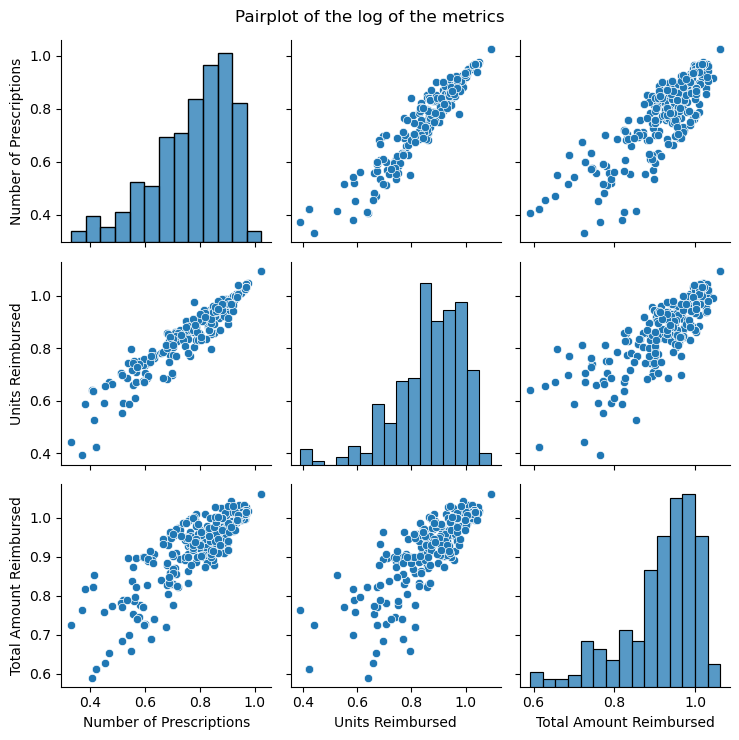

In [53]:
prescriptions = prescriptions[
    ["Number of Prescriptions", "Units Reimbursed", "Total Amount Reimbursed"]
].apply(lambda x: np.log10(x + 1))
ax = sns.pairplot(
    prescriptions[
        ["Number of Prescriptions", "Units Reimbursed", "Total Amount Reimbursed"]
    ].apply(lambda x: np.log10(x + 1)),
    vars=["Number of Prescriptions", "Units Reimbursed", "Total Amount Reimbursed"],
)
plt.suptitle("Pairplot of the log of the metrics")
plt.tight_layout()
plt.show()

The above pair plot shows the log-transformed values of three metrics: Number of Prescriptions, Units Reimbursed, and Total Amount Reimbursed. Each pairwise scatter plot illustrates the relationships between these variables, while the histograms on the diagonal show the distributions of each individual metric.

There are clear positive correlations between all three metrics. This suggests that drugs with a higher Number of Prescriptions also tend to have higher Units Reimbursed and Total Amount Reimbursed, which is logical since increased prescription rates typically lead to higher quantities and costs associated with the drugs.

The scatter plots are relatively tight and linear (on the loglog scale), particularly between Number of Prescriptions and Units Reimbursed. This indicates a strong, proportional relationship between these two metrics. The relationship between Units Reimbursed and Total Amount Reimbursed is also fairly linear, though there is slightly more variability. This could be due to differences in unit cost among drugs, which can affect the total reimbursement amount.

The histograms show that after log transformation, the distributions of each metric are more normalized (closer to a normal distribution), though they remain somewhat right-skewed. This transformation helps mitigate the effect of extremely high values and allows for a clearer analysis of the relationships between variables.



## Clinical Trials

Now we look at a potential pool of other success metrics relating to the clinical trial data linked to every ligand within BindingDB. 

The different metrics we could use are:
- The number of clinical trials associated to every ligand.
- The status and the phase of each clinical trial relating to the success of the clinical trial.
- The time related data with the start date of the clinical trials.

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

import warnings

warnings.filterwarnings("ignore")

from src.scripts.clinical_trials import load_clinical_trials_data, plot_clinical_counts

The following data was created by running the `src.scripts.clinical_trials` script which contains the following code:

```py
if __name__ == "__main__":
    df = pd.read_csv(
        os.path.join(
            os.path.dirname(os.path.abspath(__file__)),
            "..",
            "..",
            "data",
            "BindingDB_All.tsv",
        ),
        sep="\t",
        usecols=["ZINC ID of Ligand"],
    )
    data_path = os.path.join(
        os.path.dirname(os.path.abspath(__file__)),
        "..",
        "data",
        "ZINC_references_trials.json",
    )
    ids = df["ZINC ID of Ligand"].value_counts().index
    
    get_zinc_clinical_trial_data_for_all_ids(ids, data_path)
```

The above script is indicated to run for 120 hours. As a starting point we ran it for 1 hour which yielded the clinical trial data of the 3000 first most frequent ZINC ID of Ligand.

Some preliminary analysis on the resulting data is analyzed below.

In [55]:
clinical_trial_data = load_clinical_trials_data()
clinical_trial_data.describe(include="all")

code                                       description  \
count         71810                                             71750   
unique        49658                                             49392   
top     NCT02374567  Pharmacovigilance in Gerontopsychiatric Patients   
freq             53                                                53   

       status_name phase_name  start_date ZINC ID of Ligand  
count        66490      58555       70082             71810  
unique          12          7        2756               543  
top      Completed    Phase 2  2009-01-01      ZINC03875332  
freq         43247      15532         499              2015

We can see that out of the 3000 collected ZINC IDs, only 543 of them have clinical trials data associated to them. 

We also see that each clinical trial has a certain unique identifier with its `code`. For example *NCT02374567* is referenced 53 different times. We will need to verify whether each `code` is unique per ZINC ID of Ligand or if the mapping is non-injective.

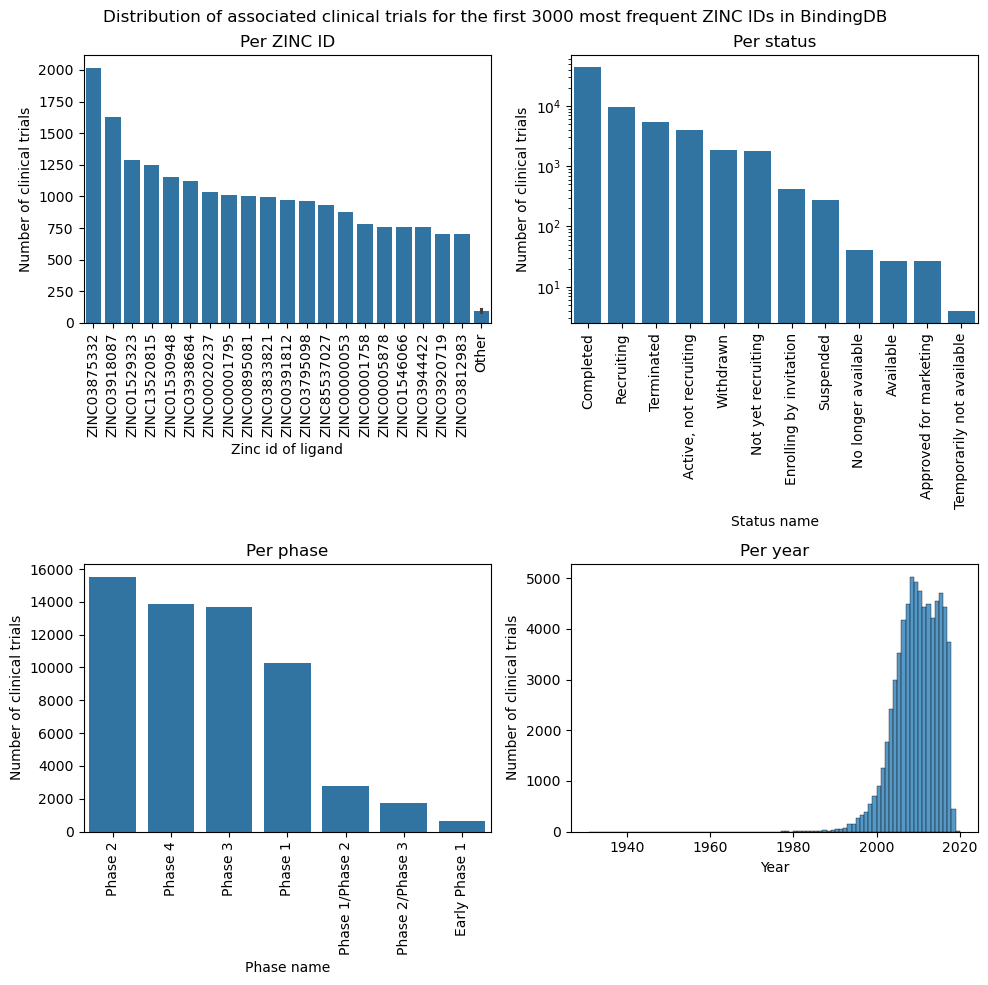

In [56]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
((ax1, ax2), (ax3, ax4)) = axes

ylabel = "Number of clinical trials"
list_kwargs = [
    dict(
        title="Per ZINC ID",
        col="ZINC ID of Ligand",
        ylabel=ylabel,
        top_n=20,
    ),
    dict(
        col="status_name",
        ylabel=ylabel,
        title="Per status",
        top_n=None,
        yscale="log",
    ),
    dict(
        col="phase_name",
        ylabel=ylabel,
        title="Per phase",
        top_n=None,
        yscale=None,
    ),
]

for ax, kwargs in zip(axes.flatten(), list_kwargs):
    plot_clinical_counts(clinical_trial_data, ax, **kwargs)

sns.histplot(
    clinical_trial_data["start_date"]
    .dropna()
    .apply(lambda date_str: datetime.date.fromisoformat(date_str).year)
    .to_frame(),
    x="start_date",
    binwidth=1,
    ax=ax4,
)
ax4.set_title("Per year")
ax4.set_xlabel("Year")
ax4.set_ylabel(ylabel)

fig.suptitle(
    "Distribution of associated clinical trials for the first 3000 most frequent ZINC IDs in BindingDB"
)

plt.tight_layout()
plt.show()

From the different distributions we see that there are 12 and 7 categories for the status and phase names respectively. The most prominent phase is phase 2, and regrouping some phases together (e.g. *Early Phase 1* into *Phase 1*). Regarding the distribution through time, we observe a similar distribution as with the diseases classes studied.

# Conclusion
These initial results show and propose multiple success metrics, which encompass research, industry and clinic. Furthermore, by analyzing molecular features, we have shown the feas feasability of linking molecular features to the success metrics we develop. All in all, we will now aim to refine the success metrics, deepen the molecular analysis and causally link these variables through statistical analysis.